# Using the PHOENIX Grid in Gollum to Model Spectra <br>
### Devloped by Michael Gully-Santiago<br>
### Documentation at https://gollum-astro.readthedocs.io/en/latest/index.html

### First, install gollum with pip
#### __Warning:__ The PHOENIX Grid is a large database of files that must be downloaded to utilize this model.<br>The download is well over 100GB and took me roughly 1.5 days to complete.

In [4]:
# pip install gollum

#### Import the necessary packages

In [1]:
from gollum.phoenix import PHOENIXSpectrum
from gollum.phoenix import PHOENIXGrid
from specutils import Spectrum1D

import os
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
from astropy import modeling
from astropy.modeling.physical_models import BlackBody
%config InlineBackend.figure_format='retina'

### Set the path to the PHOENIX Grid directory

In [2]:
path = 'D:\\PHOENIX\\phoenix.astro.physik.uni-goettingen.de\\HiResFITS\\PHOENIX-ACES-AGSS-COND-2011'

# Before we proceed with the model, let's get our HPF data and plot it up.

### First, specify the data file, open it and get some info on what it contains.

In [3]:
spectrum_path = glob.glob('Slope-*.fits')[0]
hdu_list = fits.open(spectrum_path)
hdu_list.info()
hdu_list[0].header['OBJECT']

Filename: Slope-20220301T114303_R01.optimal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     412   ()      
  1  Sci Flux      1 ImageHDU        12   (2048, 28)   float32   
  2  Sky Flux      1 ImageHDU        12   (2048, 28)   float32   
  3  Cal Flux      1 ImageHDU        12   (2048, 28)   float32   
  4  Sci Variance    1 ImageHDU        12   (2048, 28)   float32   
  5  Sky Variance    1 ImageHDU        12   (2048, 28)   float32   
  6  Cal Variance    1 ImageHDU        12   (2048, 28)   float32   
  7  Sci Wavl      1 ImageHDU        37   (2048, 28)   float64   
  8  Sky Wavl      1 ImageHDU        37   (2048, 28)   float64   
  9  Cal Wavl      1 ImageHDU        37   (2048, 28)   float64   


'NLTT_43564'

### The file we've selected contains Flux, Variance, and Wavelength data arrays for the object NLTT 43564

In [4]:
#Flux values in science are what we want, sky might possibly be interesting as a calibrator.
#The calibrator arrays are effectively useless for our purposes.
#Each array contains 28 lists of flux values corresponding to the 28 spectral orders
sci=hdu_list[1].data
sky=hdu_list[2].data
cal=hdu_list[3].data

scivar=hdu_list[4].data
skyvar=hdu_list[5].data
calvar=hdu_list[6].data

#x values for science and sky fiber data
scix=hdu_list[7].data
skyx=hdu_list[8].data
calx=hdu_list[9].data

#convert NaN pixels to 0
nans=np.isnan(sky)
sky[nans]=0

nans=np.isnan(sci)
sci[nans]=0

In [5]:
# Let's turn each 2D array into a 1D array to make referencing and plotting easier.
ysci=list(sci[0])
ysky=list(sky[0])

yscivar=list(scivar[0])
yskyvar=list(skyvar[0])

xsci=list(scix[0])
xsky=list(skyx[0])

for i in range(1,28):
    ysci+=list(sci[i])
    ysky+=list(sky[i])
    yscivar+=list(scivar[i])
    yskyvar+=list(skyvar[i])
    xsci+=list(scix[i])
    xsky+=list(skyx[i])

### Now that we have our data arrays, let's plot them.

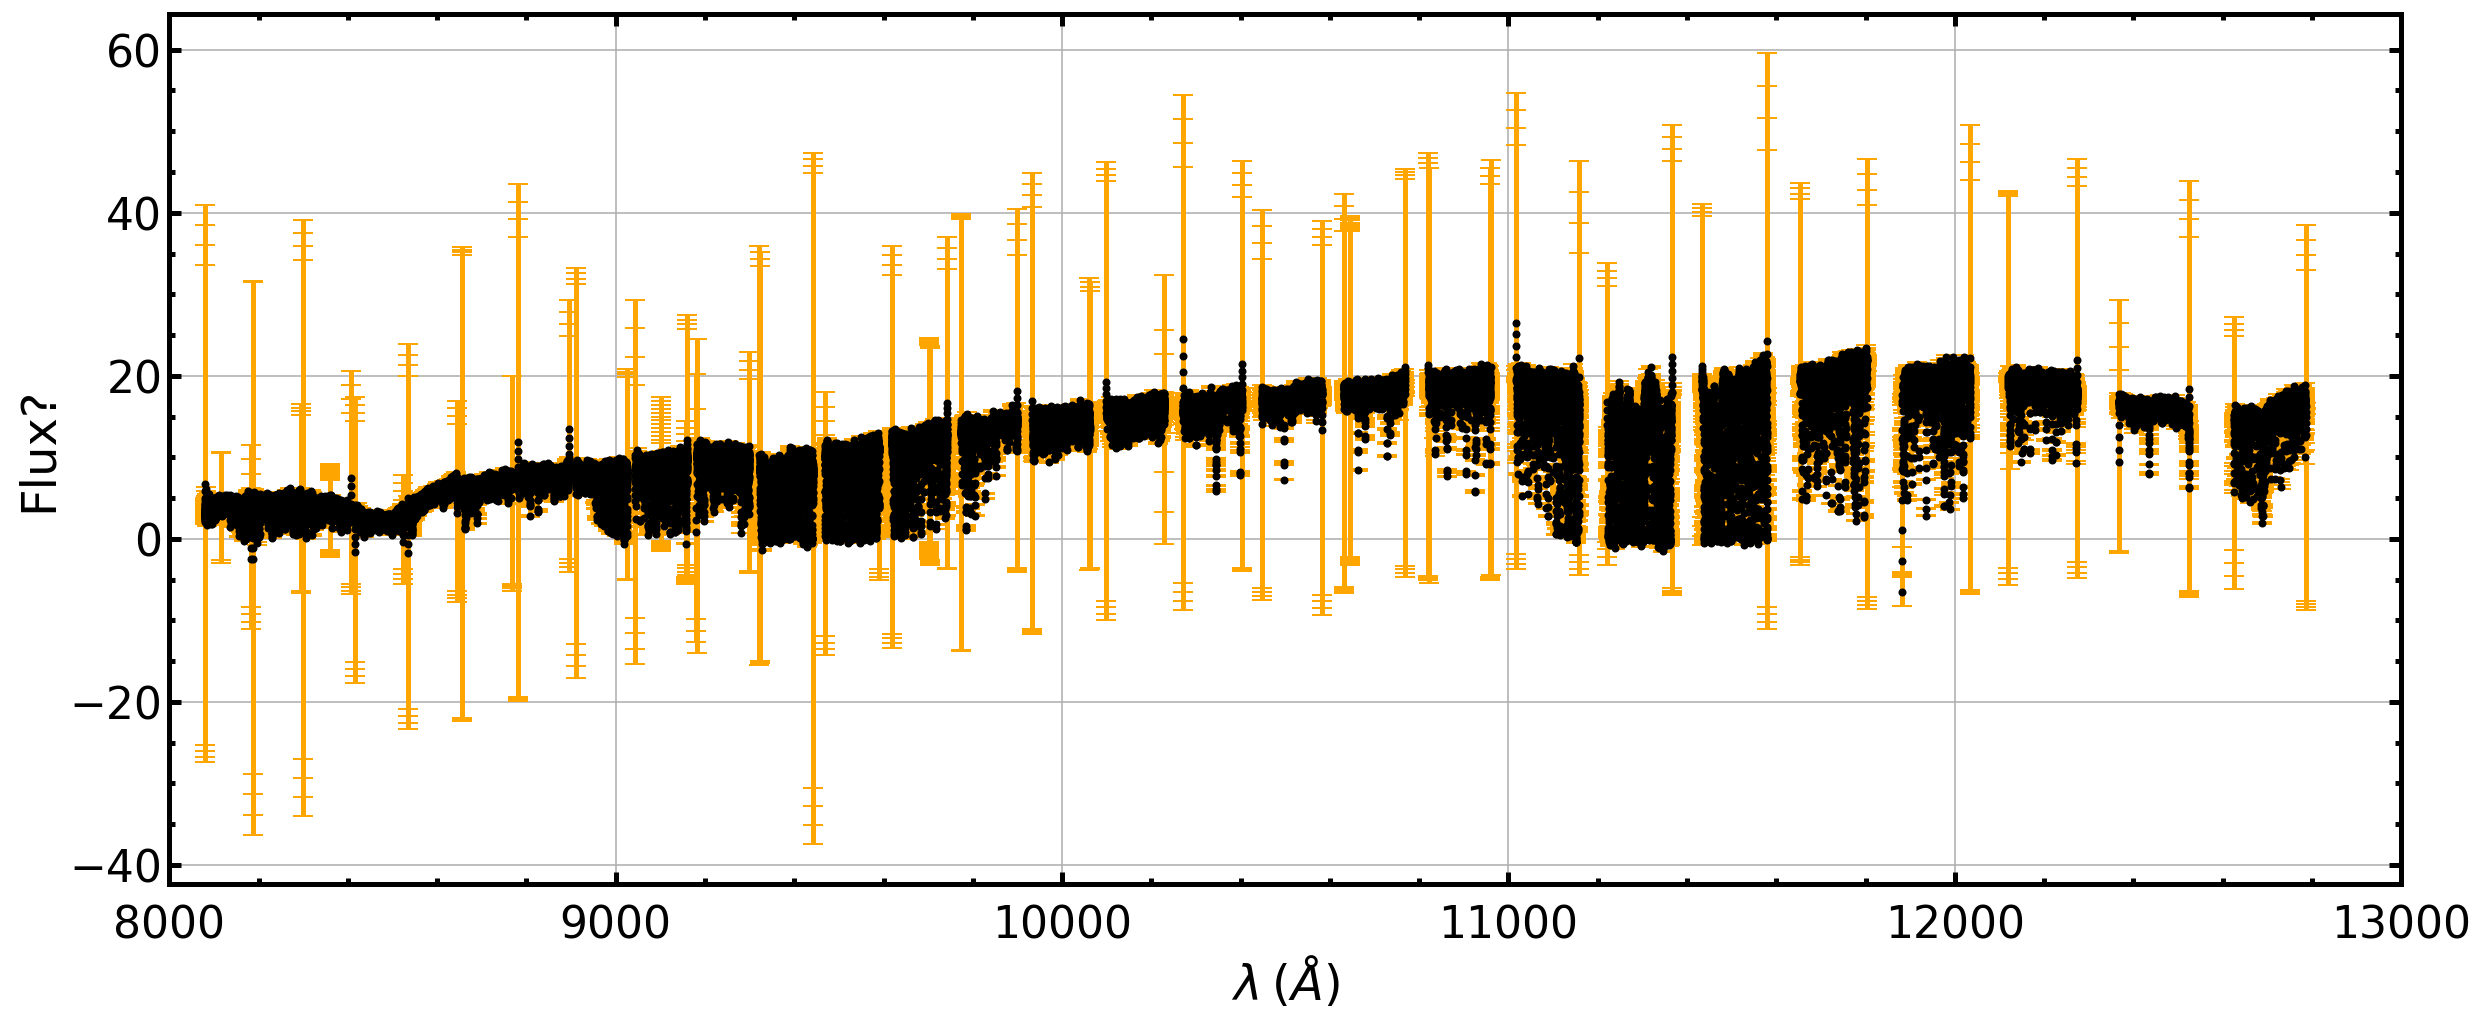

In [6]:
plt.style.use('plt_format.mplstyle') #Some predefined plotting parameters to make the plots look a bit nicer.
plt.rcParams['figure.figsize'] = 20,8
plt.errorbar(xsci,ysci,yerr=yscivar,ecolor='orange',ls='none',capsize=5,marker='o',ms=3,color='k')
plt.grid(axis='both',which='major')
plt.xlim(8000,13000)
plt.ylabel('Flux?')   # I don't know the units...
plt.xlabel(r'$\lambda \:(\AA)$')
plt.show()

### Yikes. The error on some of these points (particularly those at the ends of the orders) are huge. Let's trim those, replot and take a look at our sky fiber too.

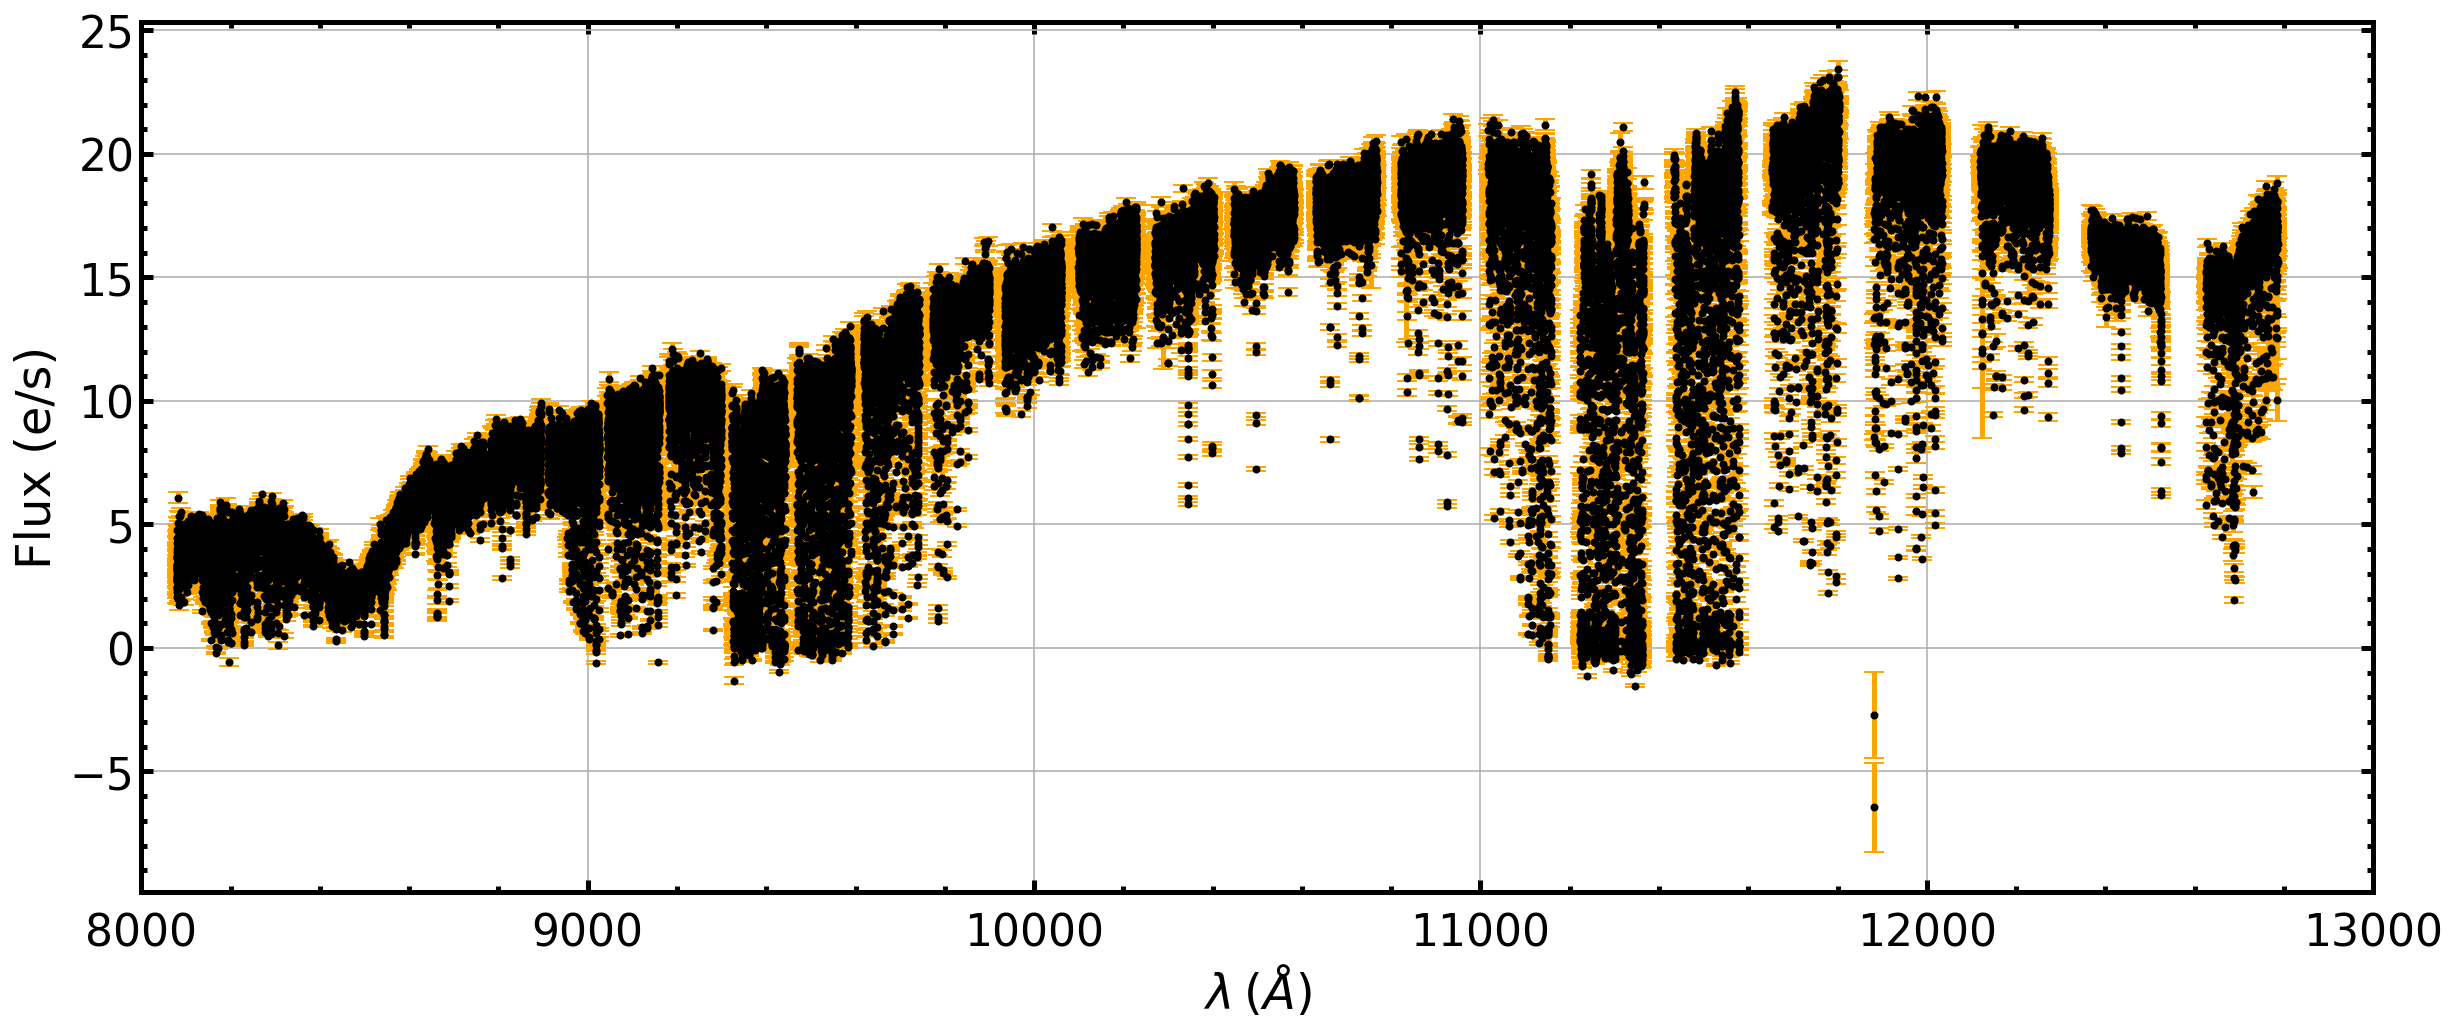

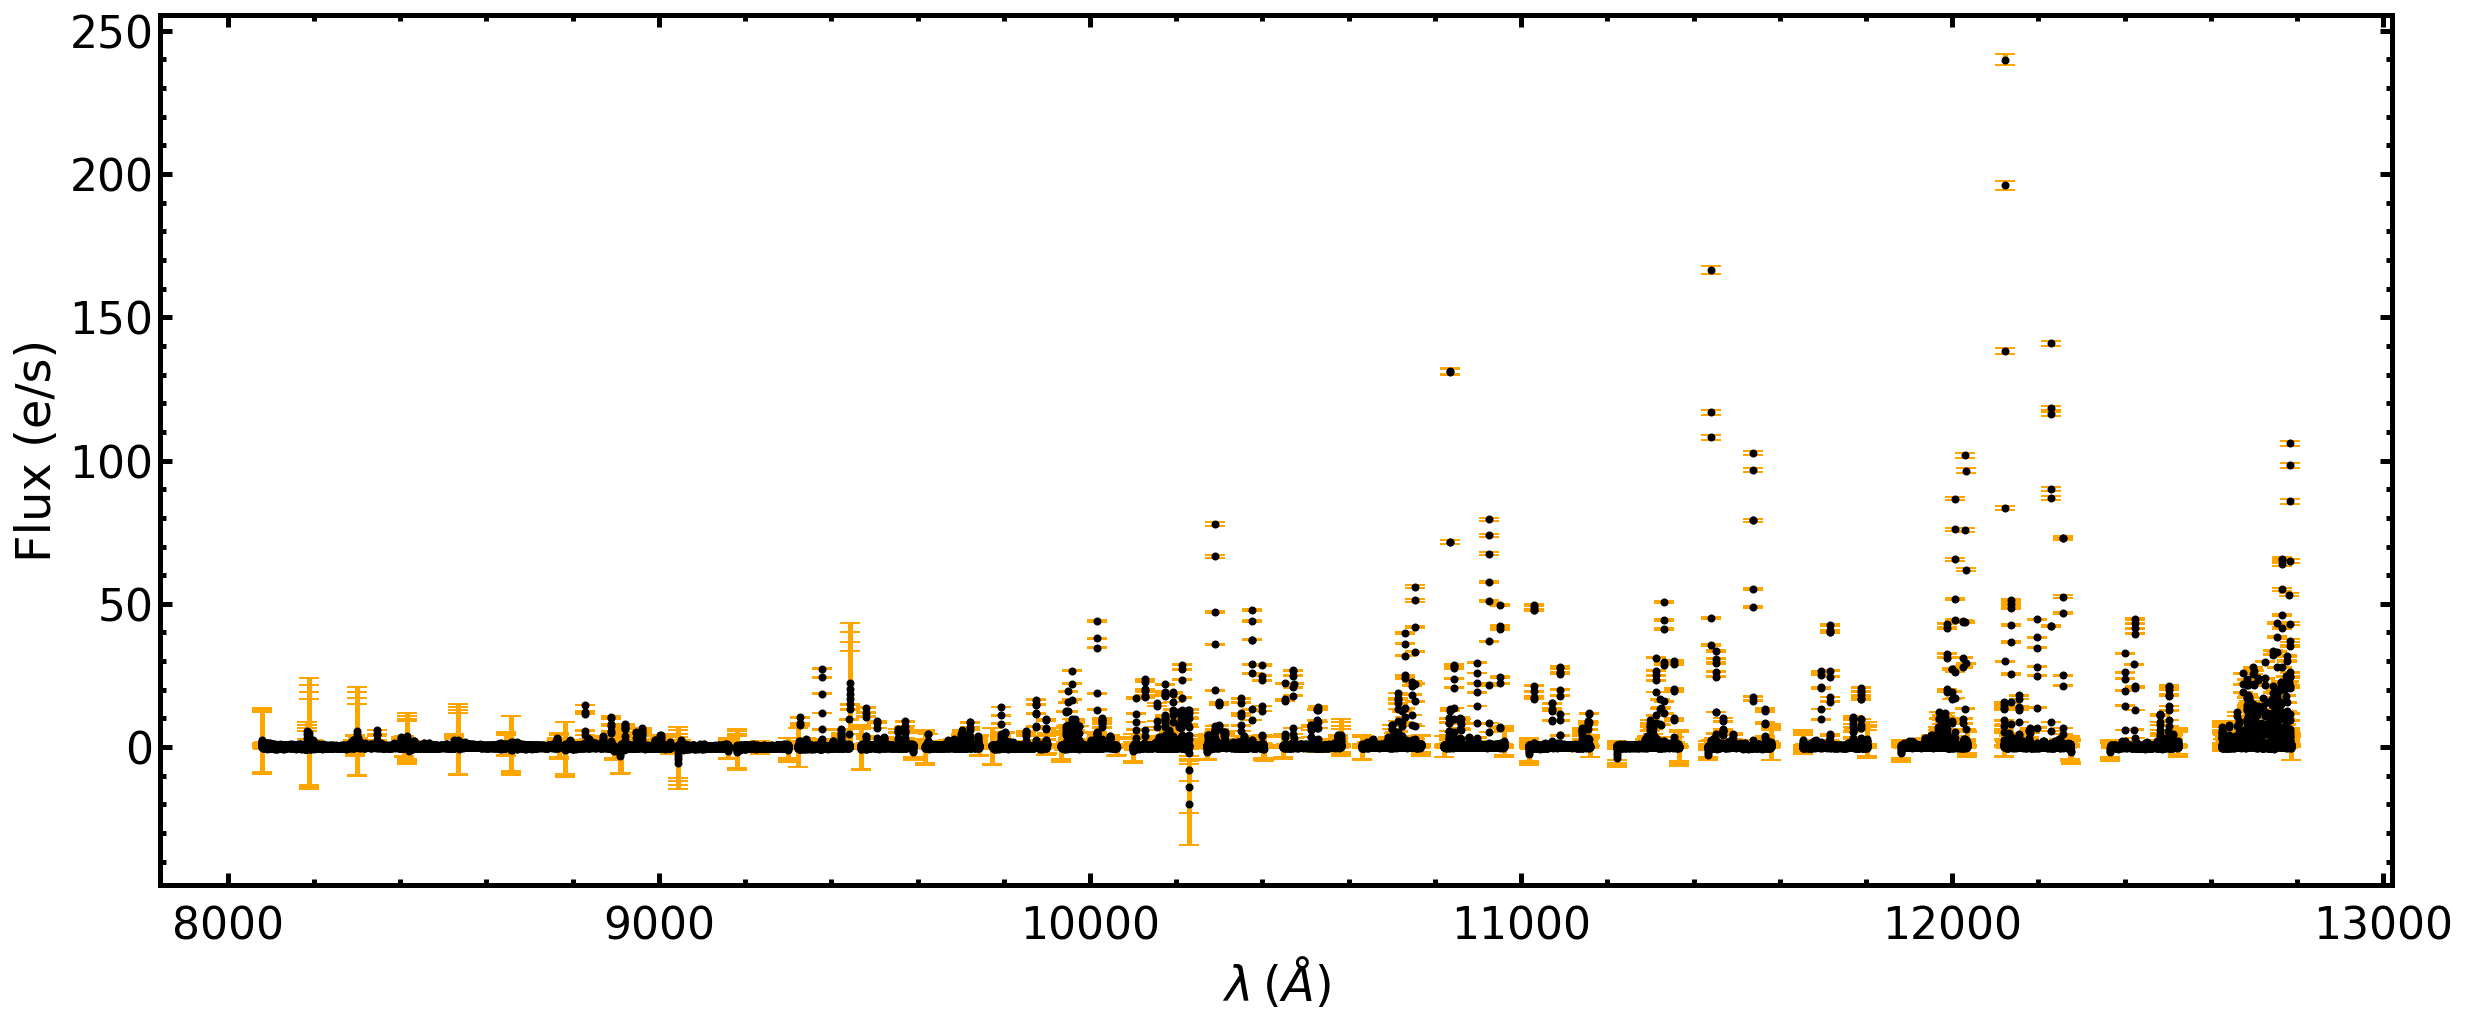

In [7]:
plt.style.use('plt_format.mplstyle')
plt.rcParams['figure.figsize'] = 20,8
xsci, ysci, yscivar = zip(*((x, y, z) for x, y, z in zip(xsci, ysci, yscivar) if abs(z) <= 4.5))
plt.errorbar(xsci,ysci,yerr=yscivar,ecolor='orange',ls='none',capsize=5,marker='o',ms=3,color='k')
plt.grid(axis='both',which='major')
plt.xlim(8000,13000)
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Flux (e/s)')
plt.show()
plt.errorbar(xsky,ysky,yerr=yskyvar,ecolor='orange',ls='none',capsize=5,marker='o',ms=3,color='k')
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Flux (e/s)')
plt.show()

### That's a bit cleaner. I happen to find out the units on the flux in these files is in electrons/second. (I'm guessing the negative points have to do with flat field subtraction.) I was given a calibrator file to convert these units to typical flux units, but that only made the spectrum worse, not better. So for now, let's just normalize this and work with what we have...<br>And let's tack on a normalized blackbody model as well just for fun...

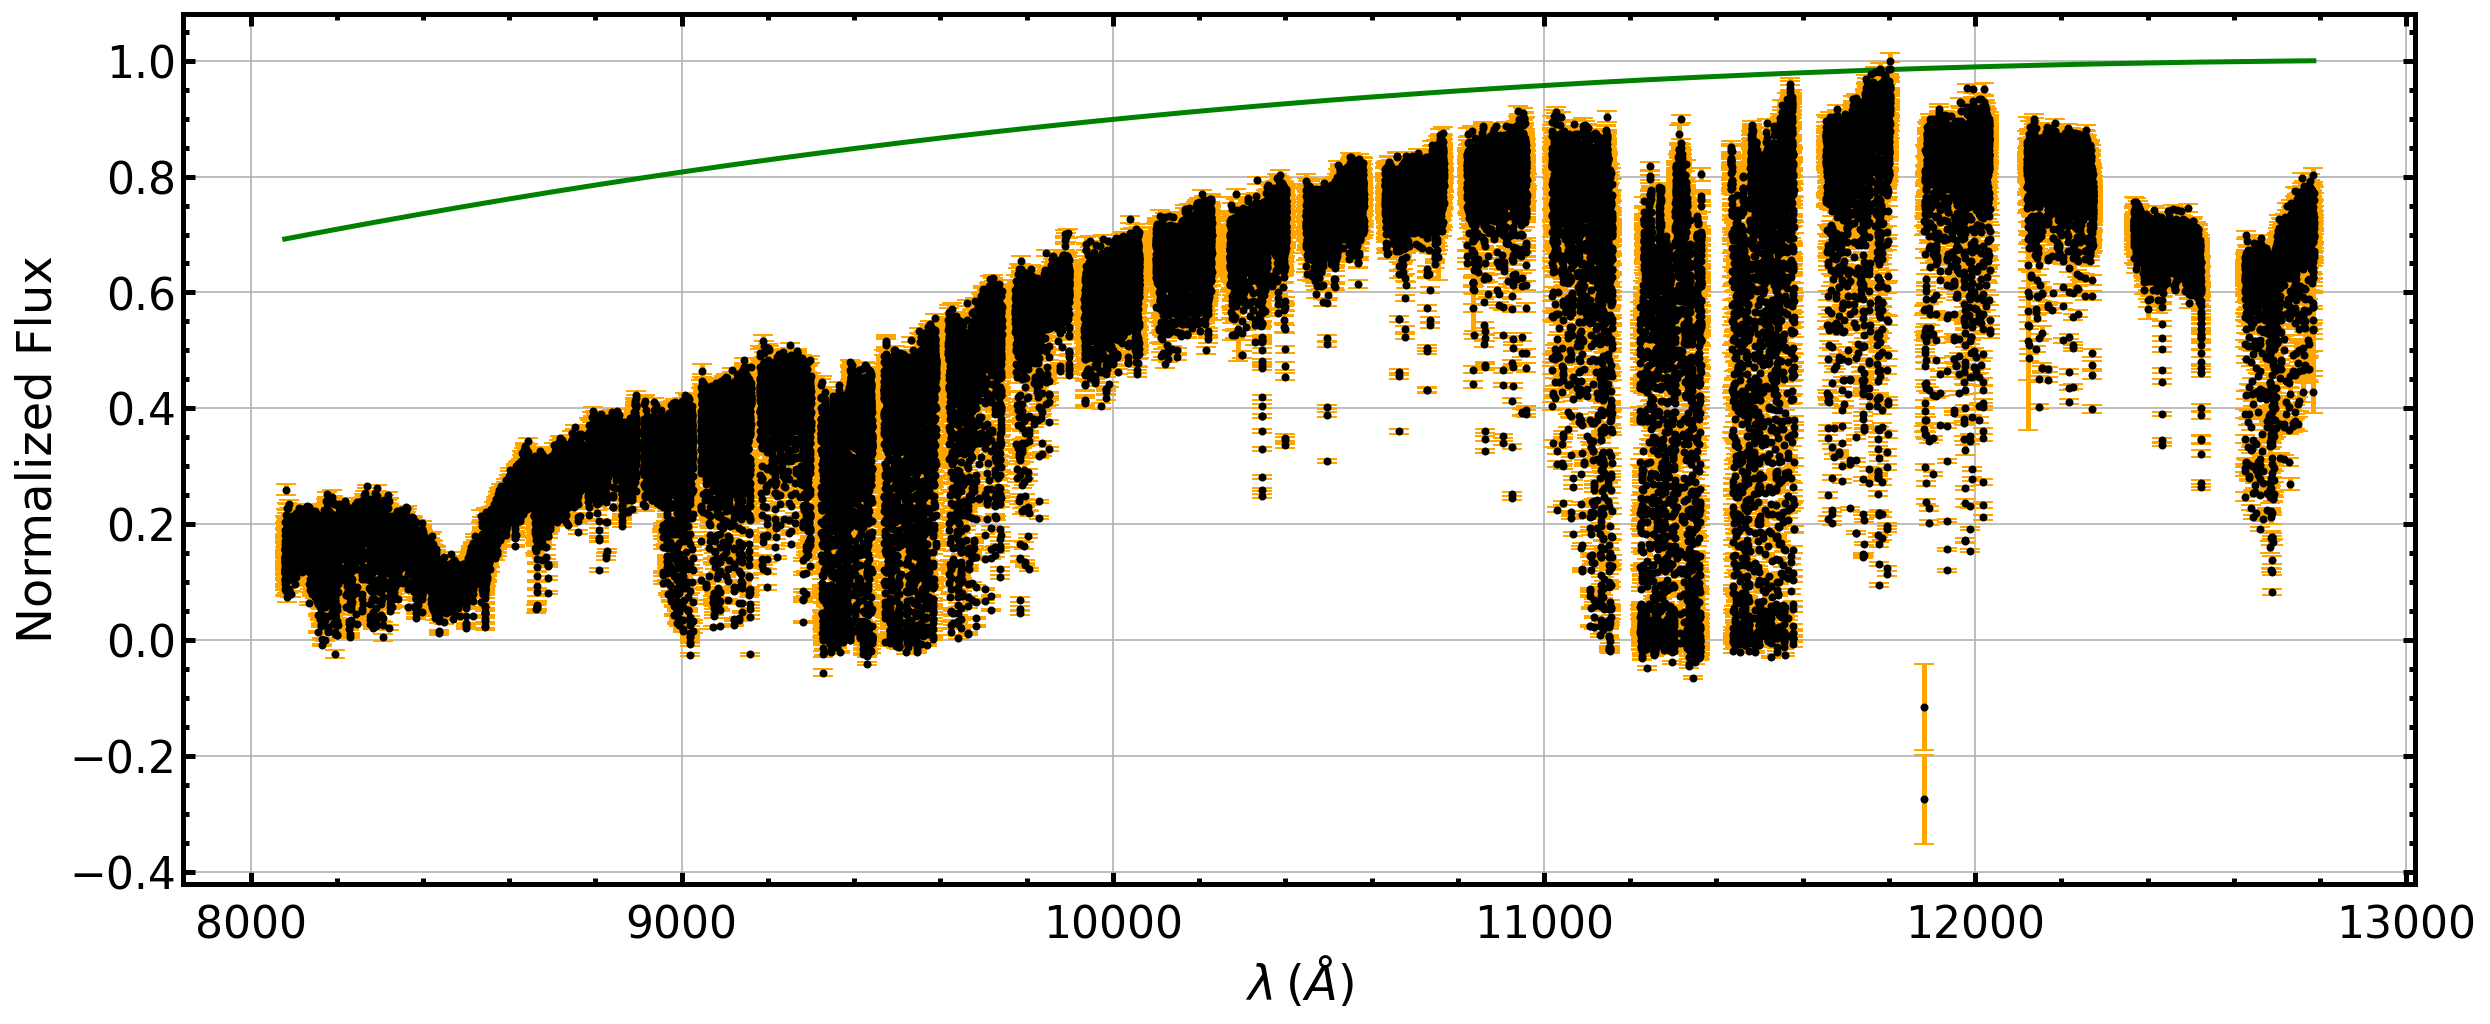

In [8]:
plt.style.use('plt_format.mplstyle')
plt.rcParams['figure.figsize'] = 20,8
xsci, ysci, yscivar = zip(*((x, y, z) for x, y, z in zip(xsci, ysci, yscivar) if abs(z) <= 4.5))
plt.errorbar(xsci,ysci/max(ysci),yerr=yscivar/max(ysci),ecolor='orange',ls='none',capsize=5,marker='o',ms=3,color='k')
# Blackbody model using NLTT 43564 Teff
Temp = 3857.61*u.K
BB_model = BlackBody(temperature=Temp)
BB = BB_model(xsci*u.AA)
plt.plot(xsci,BB/max(BB),color='g')
plt.grid(axis='both',which='major')
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Normalized Flux')
plt.show()

### Okay, that's cool looking and all, but 28 orders is a lot, especially for a high resolution spectrograph like HPF. Let's hone in on one order at a time and find some interesting features.

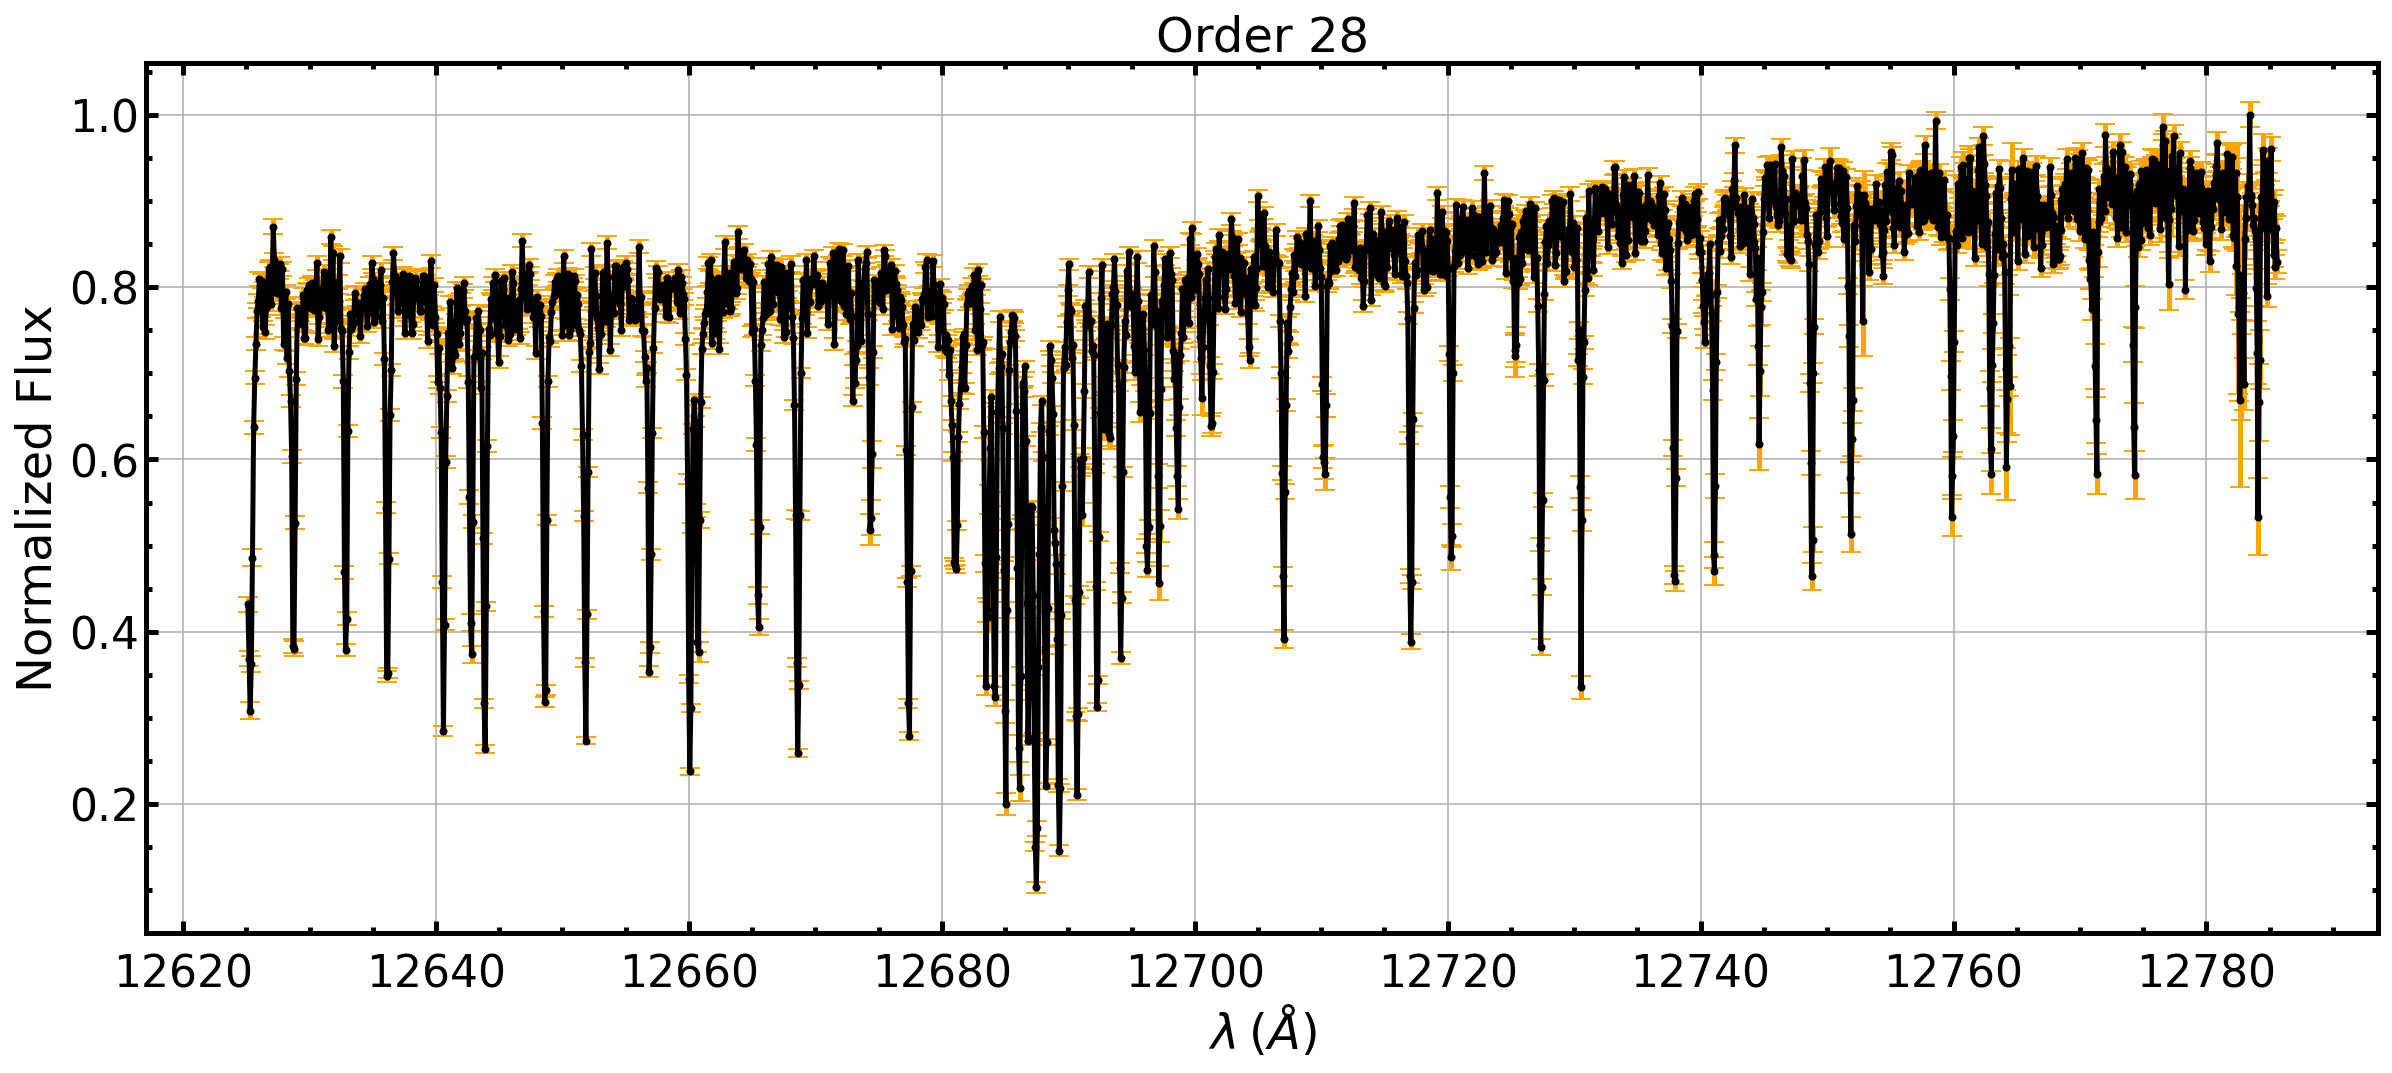

In [9]:
sci=hdu_list[1].data
scivar=hdu_list[4].data
scix=hdu_list[7].data
o = 28
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix[o-1], sci[o-1], scivar[o-1]) if abs(z) <= 4.5))
plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=5,marker='o',ms=3,color='k')
plt.grid(axis='both',which='major')
plt.title(f'Order {o}')
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Normalized Flux')
plt.show()

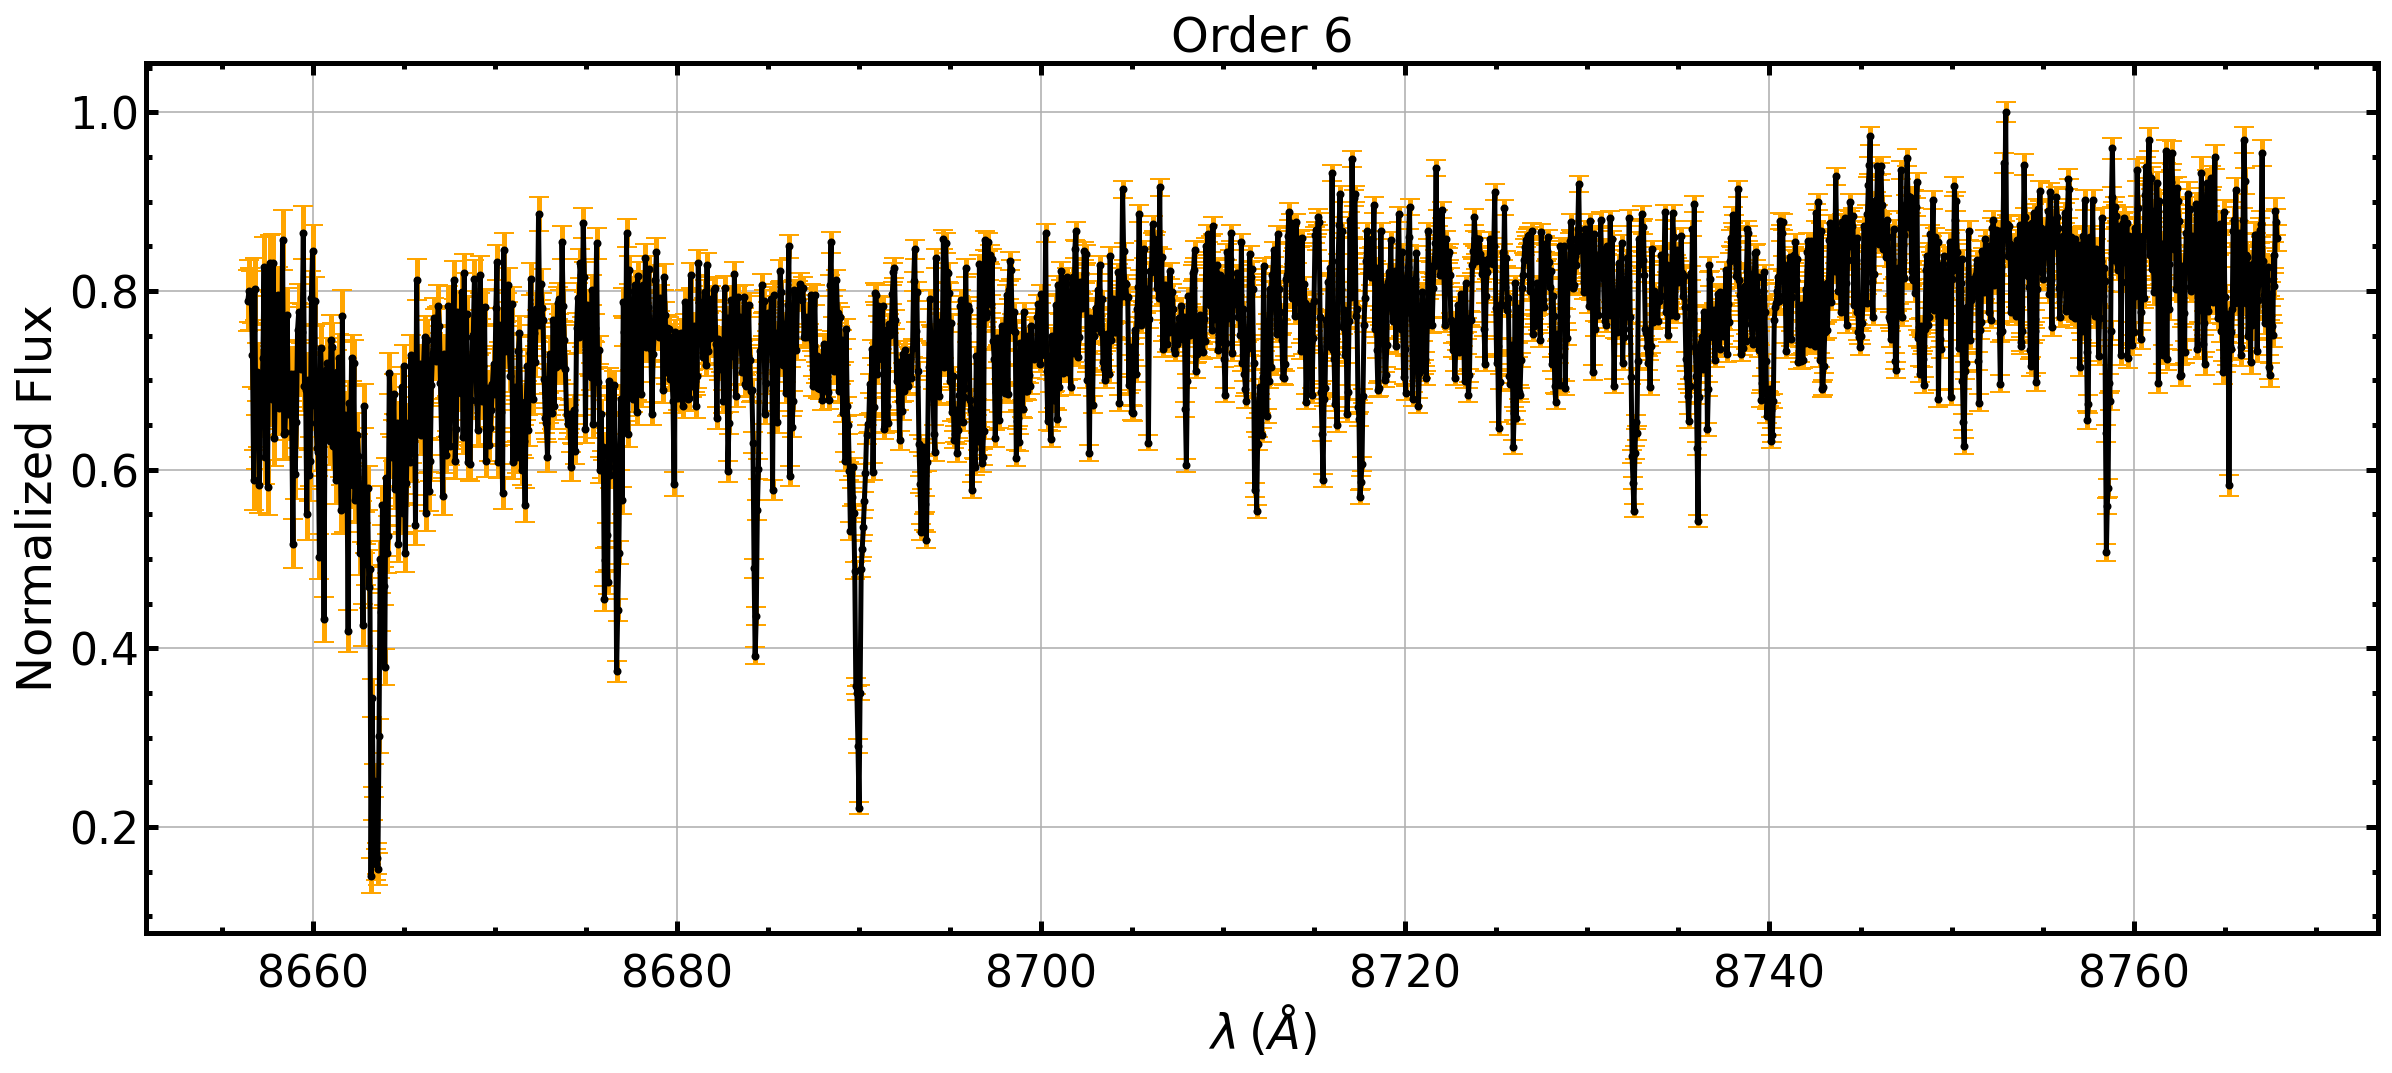

In [10]:
sci=hdu_list[1].data
scivar=hdu_list[4].data
scix=hdu_list[7].data
o = 6
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix[o-1], sci[o-1], scivar[o-1]) if abs(z) <= 4.5))
plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=5,marker='o',ms=3,color='k')
plt.grid(axis='both',which='major')
plt.title(f'Order {o}')
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Normalized Flux')
plt.show()

# Cool. We have our data. Now let's use the PHOENIX Grid to set up an interactive dashboard and compare the data vs the model.
## But what wavelength range should we look at?
## (Valenti, Piskunov, and Johns-Krull 1998) lists some interesting Fe, Ti and TiO lines, which we know should be prominent in an M dwarf atmosphere. Let's take a look.

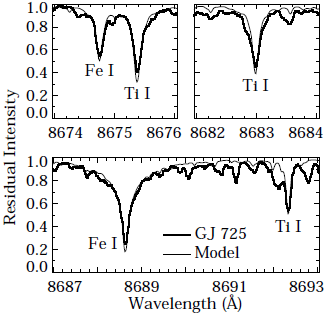

Processing Teff=4800 K, logg=5.00, Z=+0.5: 100%|██████████| 21/21 [00:26<00:00,  1.24s/it]


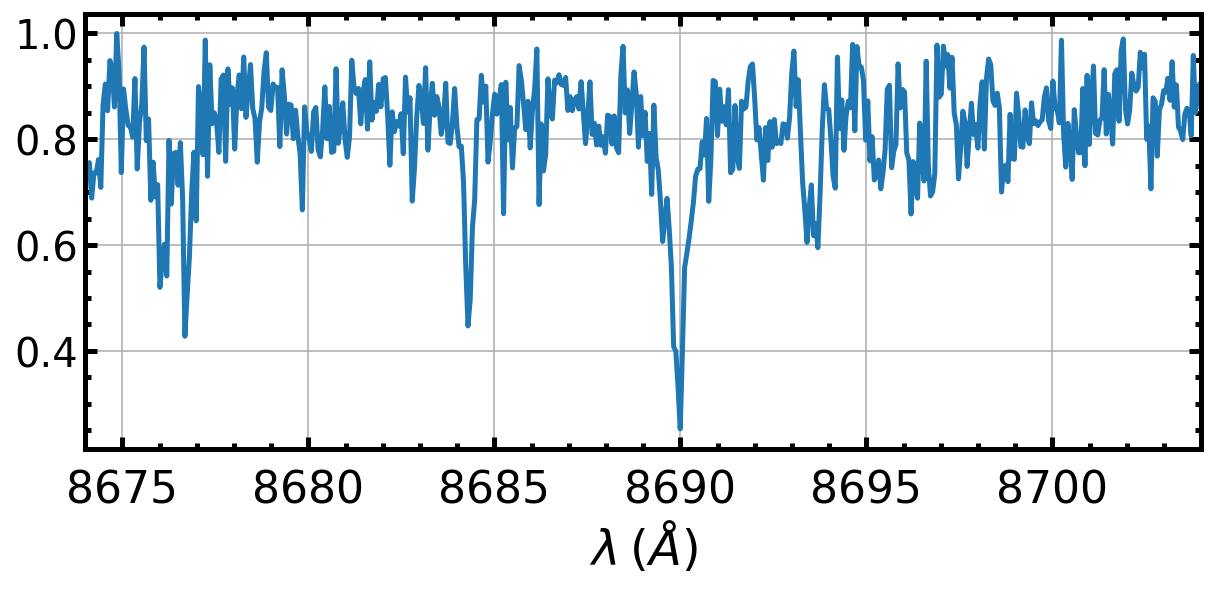

In [11]:
# Pick the order corresponding to the wavelengths you want to look at
o = 6 

# Trim the points with extra large error bars
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix[o-1], sci[o-1], scivar[o-1]) if abs(z) <= 4.5))

# Set the bounds of your wavelenth range of interest
wl_lo=8674
wl_hi=8704

# Trim the data over this range to improve normalization
x, y, z = zip(*((x, y, z) for x, y, z in zip(x, y, z) if wl_lo <= x <= wl_hi))
plt.rcParams['figure.figsize'] = 10,4
plt.rcParams['ytick.labelsize'] = 20

# Load the grid
grid = PHOENIXGrid(wl_lo=wl_lo, wl_hi=wl_hi, path=path, 
                   teff_range=[2800,4800],
                   logg_range=[3.5,5.0],
                   metallicity_range=[-0.5,0.5])

# Then plot the data
plt.plot(x,y/max(y))
# plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=2,capthick=2,marker='o',ms=3,color='k',linewidth=1)
plt.xlabel(r'$\lambda \:(\AA)$')
plt.xlim(wl_lo,wl_hi)
plt.grid(axis='both',which='major')
plt.show()

# Finally, show the interactive dashboard
grid.show_dashboard(notebook_url='localhost:8888')

---
### Cool. Let's look at more lines from Valenti, et al. 1998
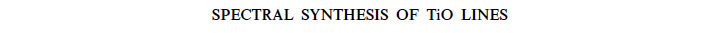
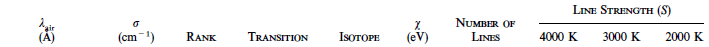


Processing Teff=4800 K, logg=5.00, Z=+0.5: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]


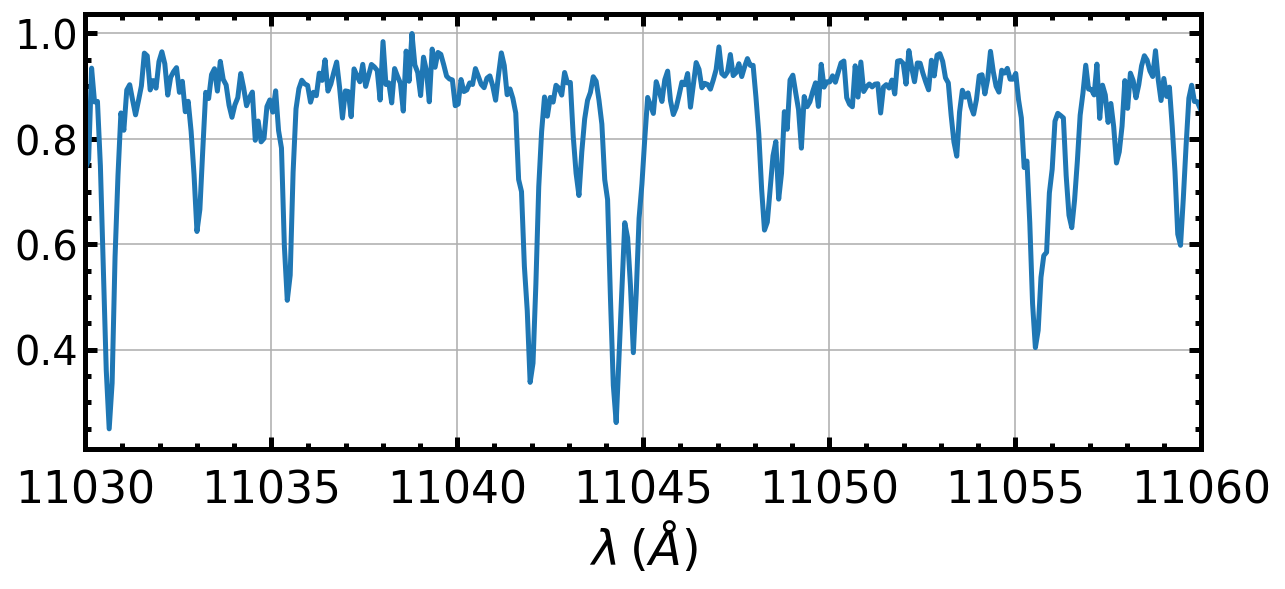

In [12]:
# Pick the order corresponding to the wavelengths you want to look at
o = 21

# Trim the points with extra large error bars
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix[o-1], sci[o-1], scivar[o-1]) if abs(z) <= 4.5))

# Set the bounds of your wavelenth range of interest
wl_lo=11030
wl_hi=11060

# Trim the data over this range to improve normalization
x, y, z = zip(*((x, y, z) for x, y, z in zip(x, y, z) if wl_lo <= x <= wl_hi))
plt.rcParams['figure.figsize'] = 10,4
plt.rcParams['ytick.labelsize'] = 20

# Load the grid
grid = PHOENIXGrid(wl_lo=wl_lo, wl_hi=wl_hi, path=path, 
                   teff_range=[2800,4800],
                   logg_range=[3.5,5.0],
                   metallicity_range=[-0.5,0.5])

# Then plot the data
plt.plot(x,y/max(y))
# plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=2,capthick=2,marker='o',ms=3,color='k',linewidth=1)
plt.xlabel(r'$\lambda \:(\AA)$')
plt.xlim(wl_lo,wl_hi)
plt.grid(axis='both',which='major')
plt.show()

# Finally, show the interactive dashboard
grid.show_dashboard(notebook_url='localhost:8888')

---
## Let's revisit that line from the ExoJAX Model Spectrum

Processing Teff=4800 K, logg=5.00, Z=+0.5: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s]


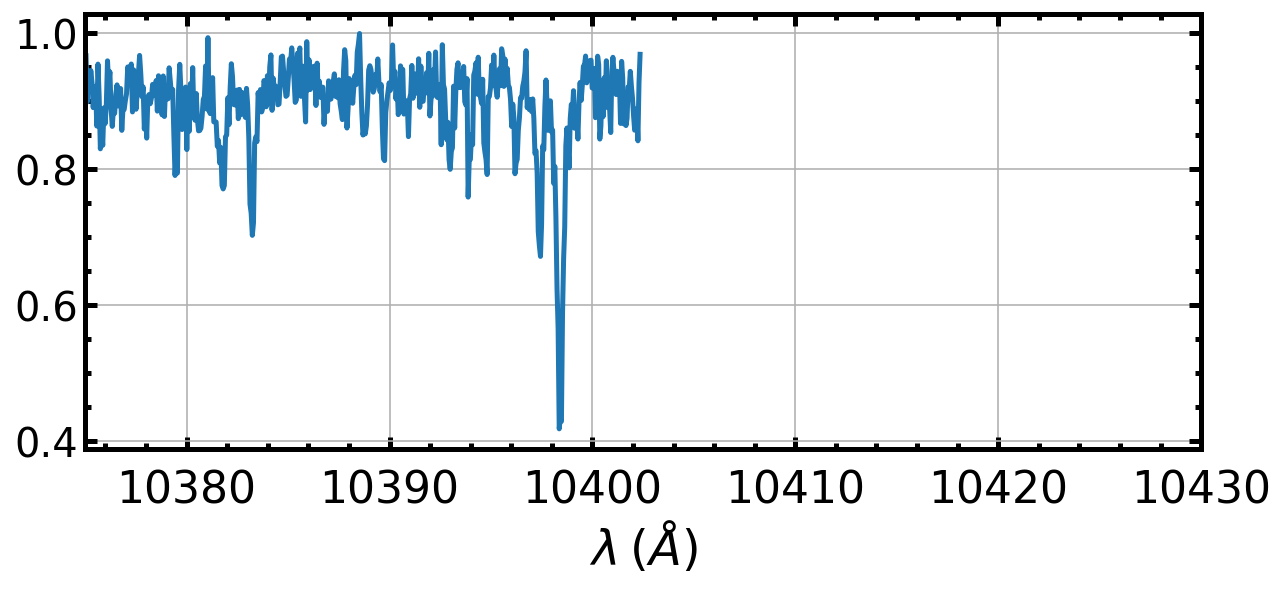

In [13]:
# Pick the order corresponding to the wavelengths you want to look at
o = 17

# Trim the points with extra large error bars
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix[o-1], sci[o-1], scivar[o-1]) if abs(z) <= 4.5))

# Set the bounds of your wavelenth range of interest
wl_lo=10375
wl_hi=10430

# Trim the data over this range to improve normalization
x, y, z = zip(*((x, y, z) for x, y, z in zip(x, y, z) if wl_lo <= x <= wl_hi))
plt.rcParams['figure.figsize'] = 10,4
plt.rcParams['ytick.labelsize'] = 20

# Load the grid
grid = PHOENIXGrid(wl_lo=wl_lo, wl_hi=wl_hi, path=path, 
                   teff_range=[2800,4800],
                   logg_range=[3.5,5.0],
                   metallicity_range=[-0.5,0.5])

# Then plot the data
plt.plot(x,y/max(y))
# plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=2,capthick=2,marker='o',ms=3,color='k',linewidth=1)
plt.xlabel(r'$\lambda \:(\AA)$')
plt.xlim(wl_lo,wl_hi)
plt.grid(axis='both',which='major')
plt.show()

# Finally, show the interactive dashboard
grid.show_dashboard(notebook_url='localhost:8888')

---
## Let's see if we can find the HeI triplet at 10833 that Shubham talked about in his defense...

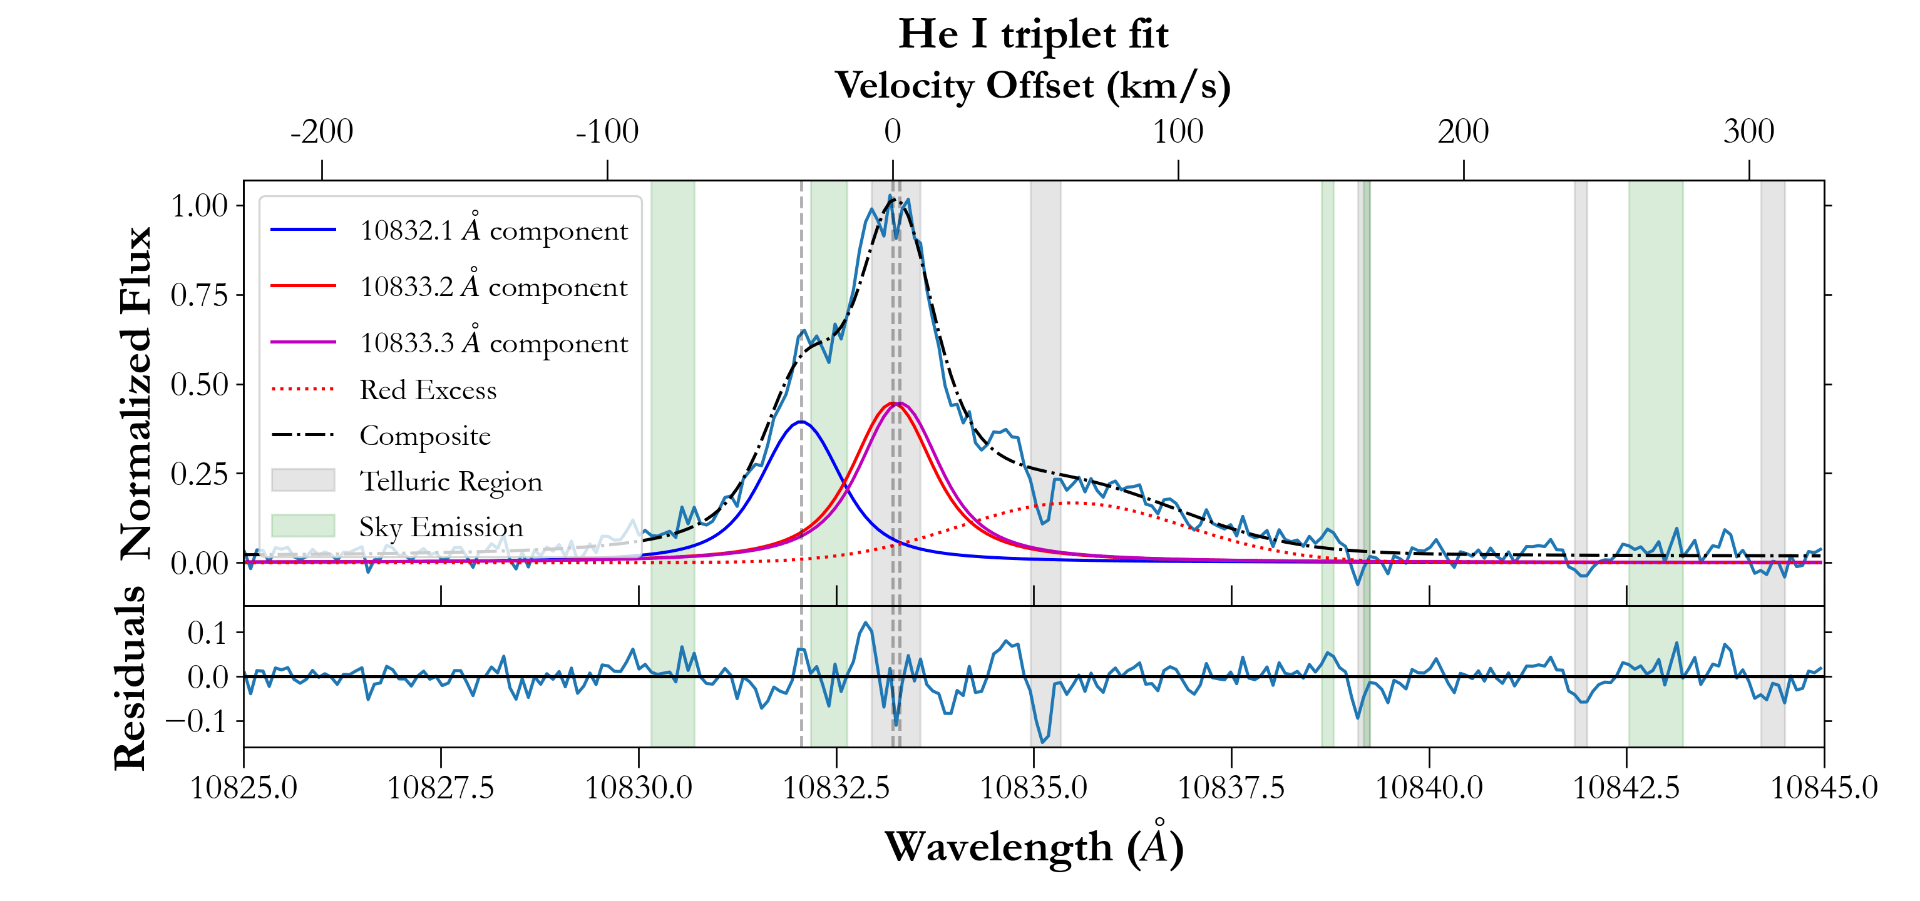

Processing Teff=4800 K, logg=5.00, Z=+0.5: 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]


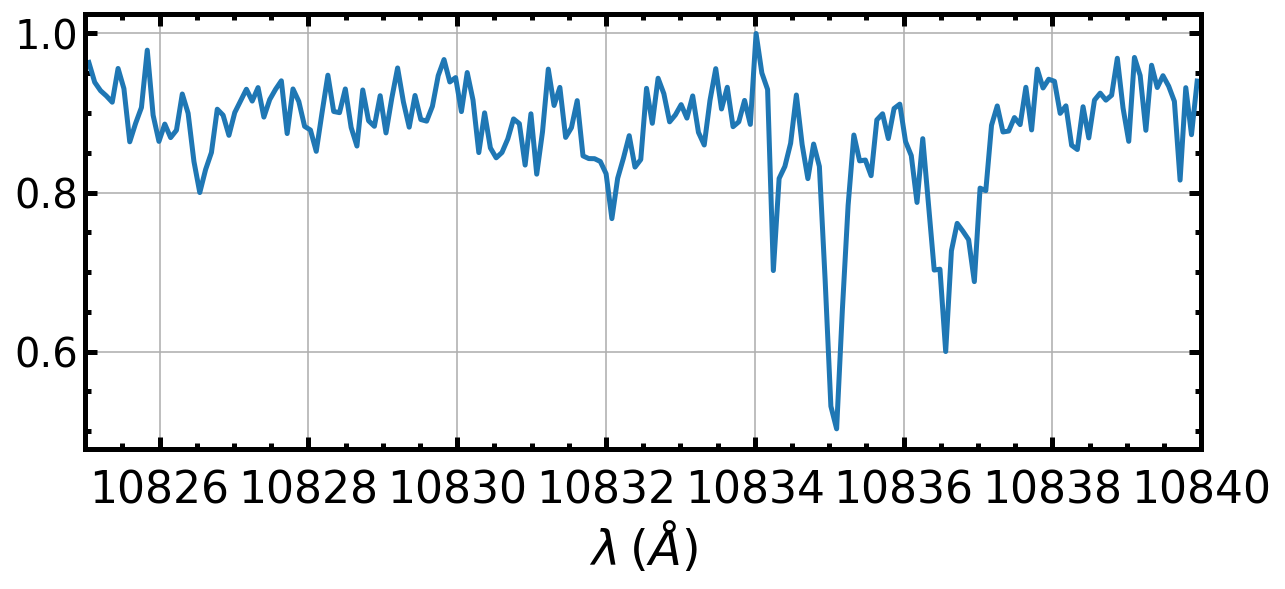

In [14]:
# Pick the order corresponding to the wavelengths you want to look at
o = 20

# Trim the points with extra large error bars
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix[o-1], sci[o-1], scivar[o-1]) if abs(z) <= 4.5))

# Set the bounds of your wavelenth range of interest
wl_lo=10825
wl_hi=10840

# Trim the data over this range to improve normalization
x, y, z = zip(*((x, y, z) for x, y, z in zip(x, y, z) if wl_lo <= x <= wl_hi))
plt.rcParams['figure.figsize'] = 10,4
plt.rcParams['ytick.labelsize'] = 20

# Load the grid
grid = PHOENIXGrid(wl_lo=wl_lo, wl_hi=wl_hi, path=path, 
                   teff_range=[2800,4800],
                   logg_range=[3.5,5.0],
                   metallicity_range=[-0.5,0.5])

# Then plot the data
plt.plot(x,y/max(y))
# plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=2,capthick=2,marker='o',ms=3,color='k',linewidth=1)
plt.xlabel(r'$\lambda \:(\AA)$')
plt.xlim(wl_lo,wl_hi)
plt.grid(axis='both',which='major')
plt.show()

# Finally, show the interactive dashboard
grid.show_dashboard(notebook_url='localhost:8888')

---
## How about that huge feature in order 28?

Processing Teff=4800 K, logg=5.00, Z=+0.5: 100%|██████████| 21/21 [00:06<00:00,  3.11it/s]


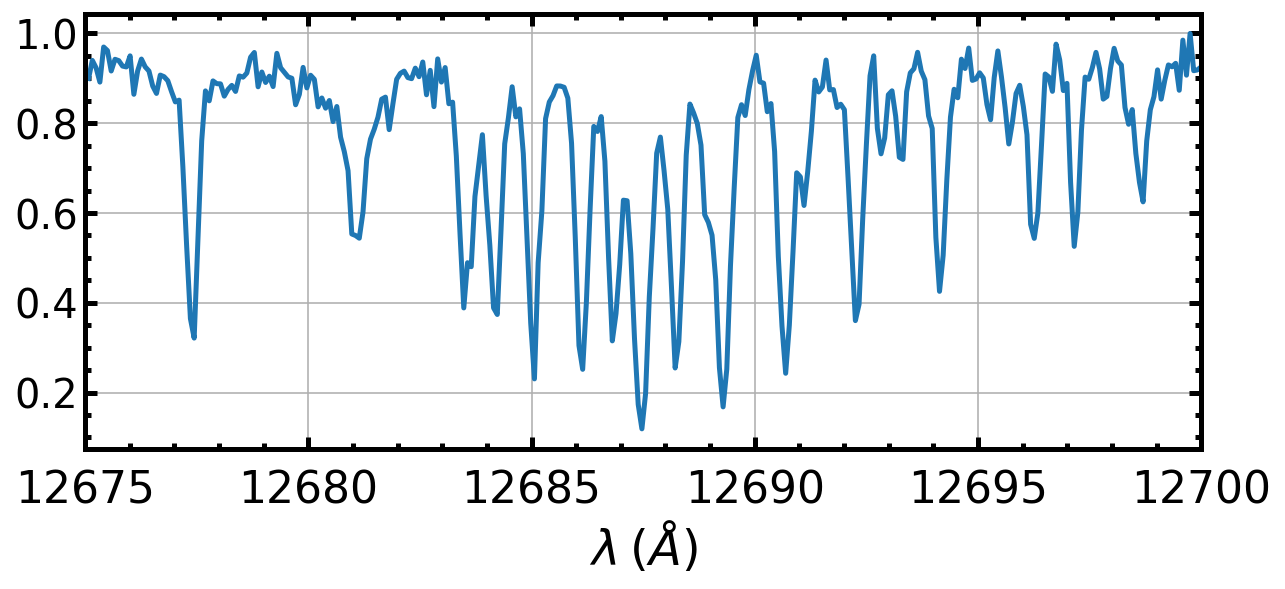

In [15]:
# Pick the order corresponding to the wavelengths you want to look at
o = 28

# Trim the points with extra large error bars
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix[o-1], sci[o-1], scivar[o-1]) if abs(z) <= 4.5))

# Set the bounds of your wavelenth range of interest
wl_lo=12675
wl_hi=12700

# Trim the data over this range to improve normalization
x, y, z = zip(*((x, y, z) for x, y, z in zip(x, y, z) if wl_lo <= x <= wl_hi))
plt.rcParams['figure.figsize'] = 10,4
plt.rcParams['ytick.labelsize'] = 20

# Load the grid
grid = PHOENIXGrid(wl_lo=wl_lo, wl_hi=wl_hi, path=path, 
                   teff_range=[2800,4800],
                   logg_range=[3.5,5.0],
                   metallicity_range=[-0.5,0.5])

# Then plot the data
plt.plot(x,y/max(y))
# plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=2,capthick=2,marker='o',ms=3,color='k',linewidth=1)
plt.xlabel(r'$\lambda \:(\AA)$')
plt.xlim(wl_lo,wl_hi)
plt.grid(axis='both',which='major')
plt.show()

# Finally, show the interactive dashboard
grid.show_dashboard(notebook_url='localhost:8888')

---
# That was interesting. But that was all looking at one a poorly characterized star. How about we take a look at a better star:

# GJ699 - Barnard's Star
---

In [16]:
# Barnard's Star
GJ699=glob.glob('GJ699*.fits')[0]
hdu_list_GJ699 = fits.open(GJ699)
hdu_list_GJ699.info()

hdu_list_GJ699[0].header['OBJECT']

Filename: GJ699-Slope-20220325T104319_R01.optimal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     412   ()      
  1  Sci Flux      1 ImageHDU        12   (2048, 28)   float32   
  2  Sky Flux      1 ImageHDU        12   (2048, 28)   float32   
  3  Cal Flux      1 ImageHDU        12   (2048, 28)   float32   
  4  Sci Variance    1 ImageHDU        12   (2048, 28)   float32   
  5  Sky Variance    1 ImageHDU        12   (2048, 28)   float32   
  6  Cal Variance    1 ImageHDU        12   (2048, 28)   float32   
  7  Sci Wavl      1 ImageHDU        37   (2048, 28)   float64   
  8  Sky Wavl      1 ImageHDU        37   (2048, 28)   float64   
  9  Cal Wavl      1 ImageHDU        37   (2048, 28)   float64   


'GJ_699'

In [17]:
#Same as before, flux, sky, and wavelength data in 28 orders
sci_GJ699=hdu_list_GJ699[1].data
sky_GJ699=hdu_list_GJ699[2].data

scivar_GJ699=hdu_list_GJ699[4].data
skyvar_GJ699=hdu_list_GJ699[5].data

#x values for science and sky fiber data
scix_GJ699=hdu_list_GJ699[7].data
skyx_GJ699=hdu_list_GJ699[8].data

#convert NaN pixels to 0
nans_GJ699=np.isnan(sky_GJ699)
sky_GJ699[nans_GJ699]=0

nans_GJ699=np.isnan(sci_GJ699)
sci_GJ699[nans_GJ699]=0

ysci_GJ699=list(sci_GJ699[0])
ysky_GJ699=list(sky_GJ699[0])

yscivar_GJ699=list(scivar_GJ699[0])
yskyvar_GJ699=list(skyvar_GJ699[0])

xsci_GJ699=list(scix_GJ699[0])
xsky_GJ699=list(skyx_GJ699[0])

for i in range(1,28):
    ysci_GJ699+=list(sci_GJ699[i])
    ysky_GJ699+=list(sky_GJ699[i])
    yscivar_GJ699+=list(scivar_GJ699[i])
    yskyvar_GJ699+=list(skyvar_GJ699[i])
    xsci_GJ699+=list(scix_GJ699[i])
    xsky_GJ699+=list(skyx_GJ699[i])

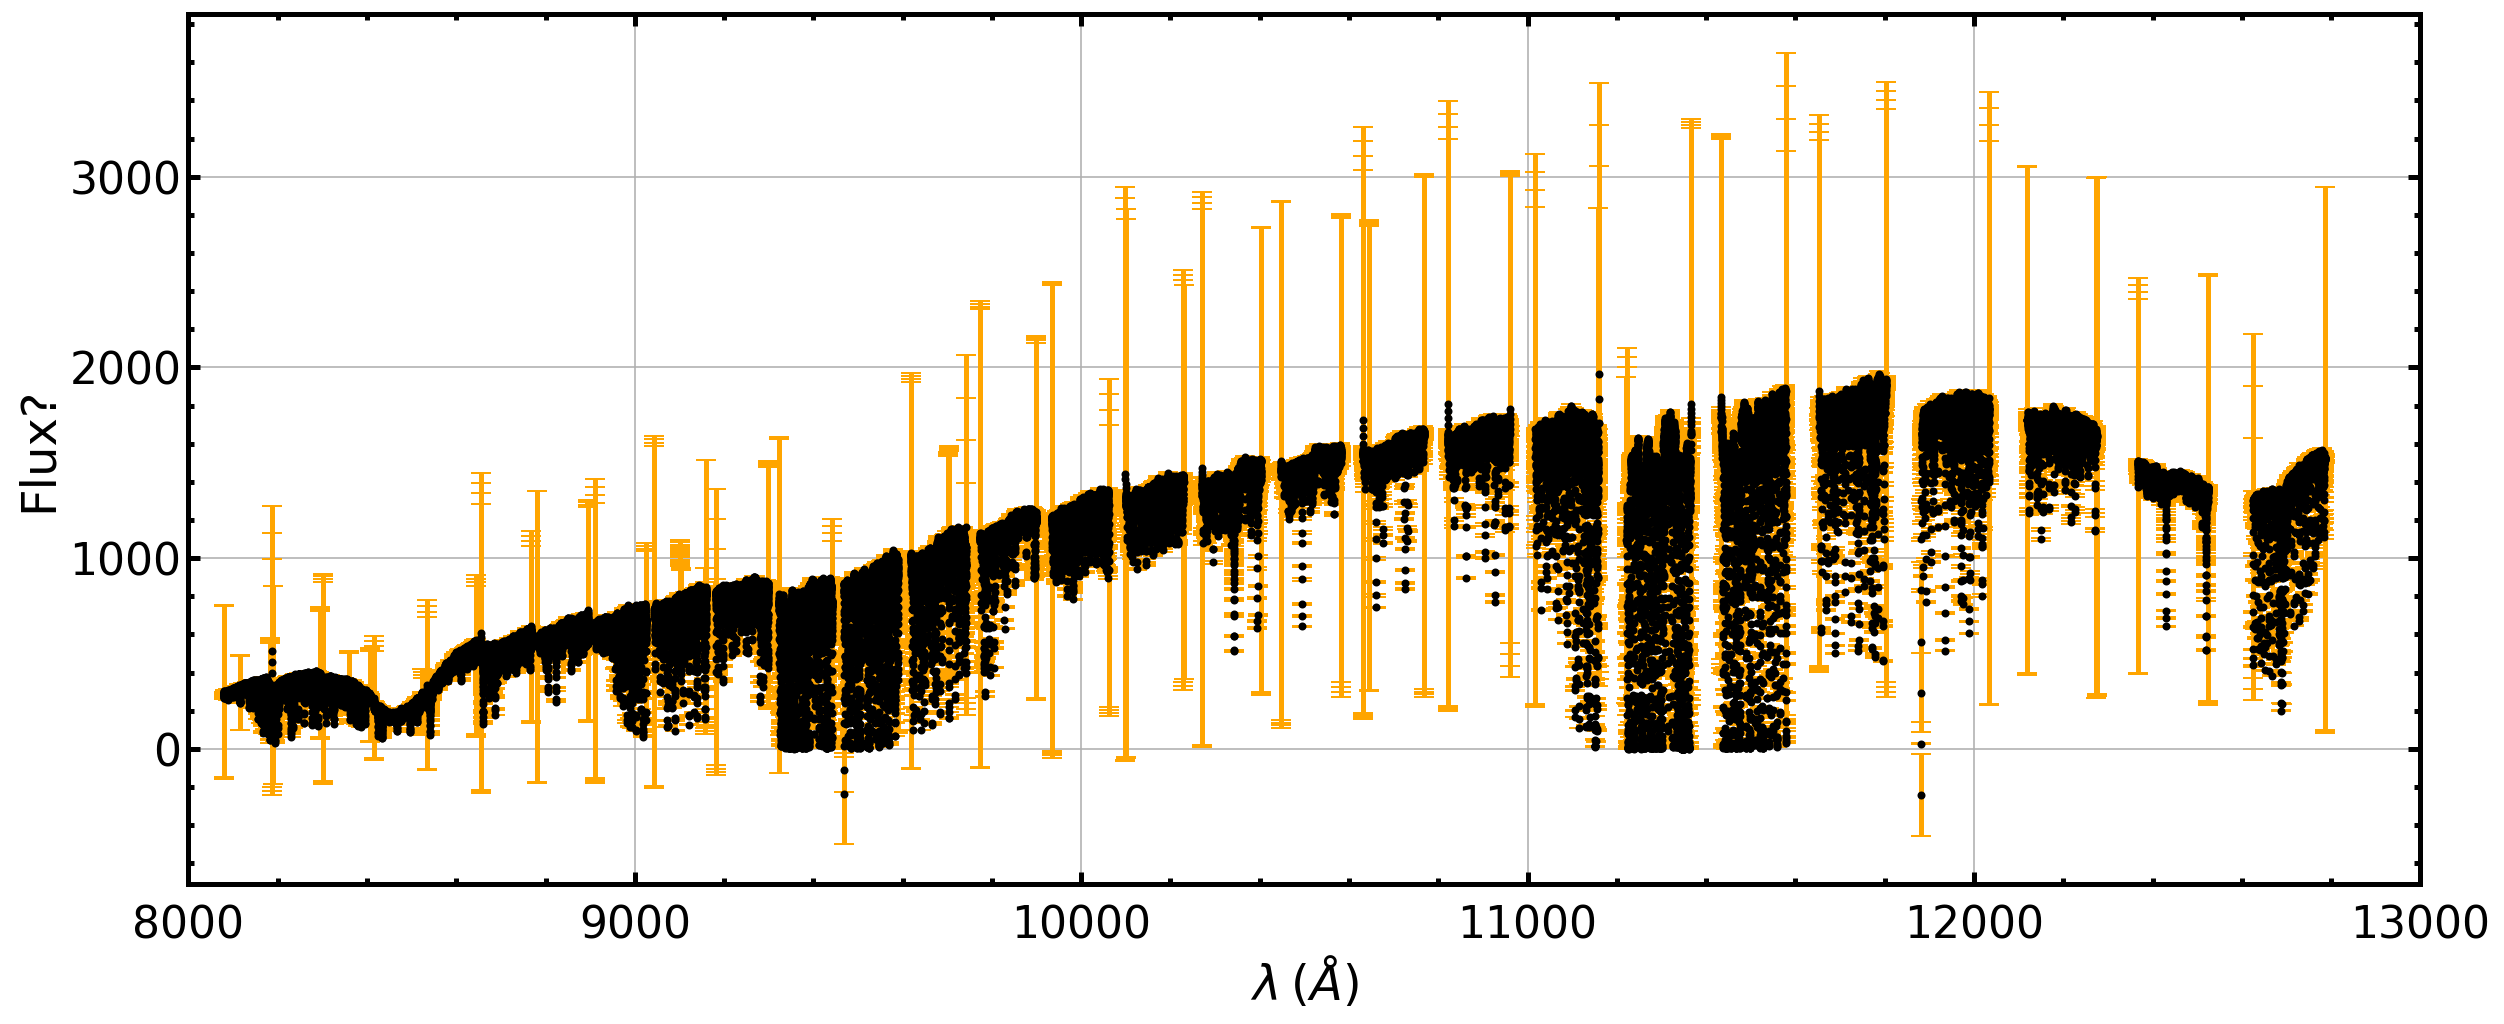

In [18]:
plt.style.use('plt_format.mplstyle') #Some predefined plotting parameters to make the plots look a bit nicer.
plt.rcParams['figure.figsize'] = 20,8
plt.errorbar(xsci_GJ699,ysci_GJ699,yerr=yscivar_GJ699,ecolor='orange',ls='none',capsize=5,marker='o',ms=3,color='k')
plt.grid(axis='both',which='major')
plt.xlim(8000,13000)
plt.ylabel('Flux?')   # I don't know the units...
plt.xlabel(r'$\lambda \:(\AA)$')
plt.show()

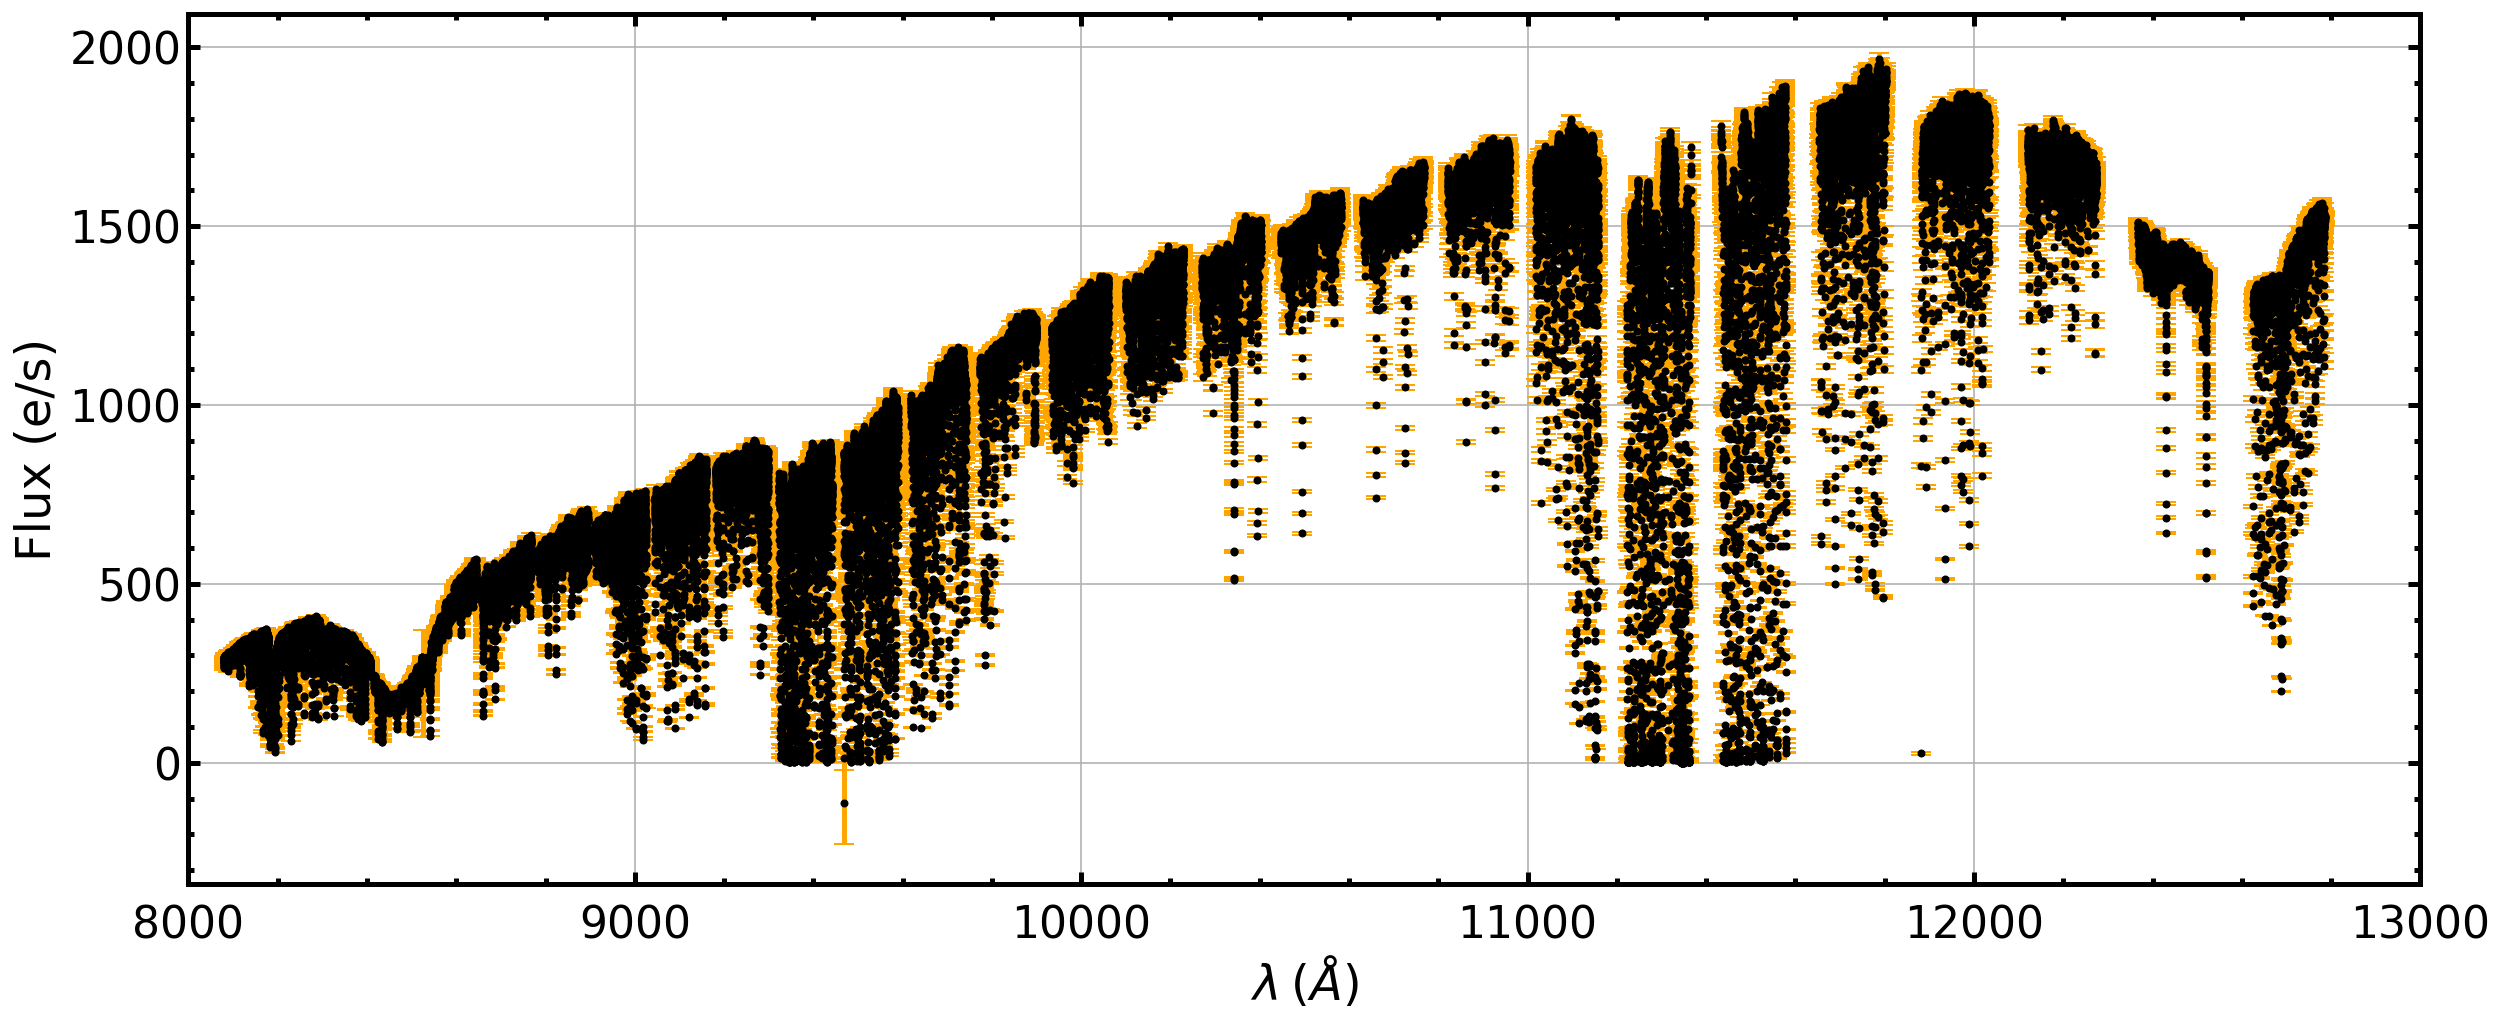

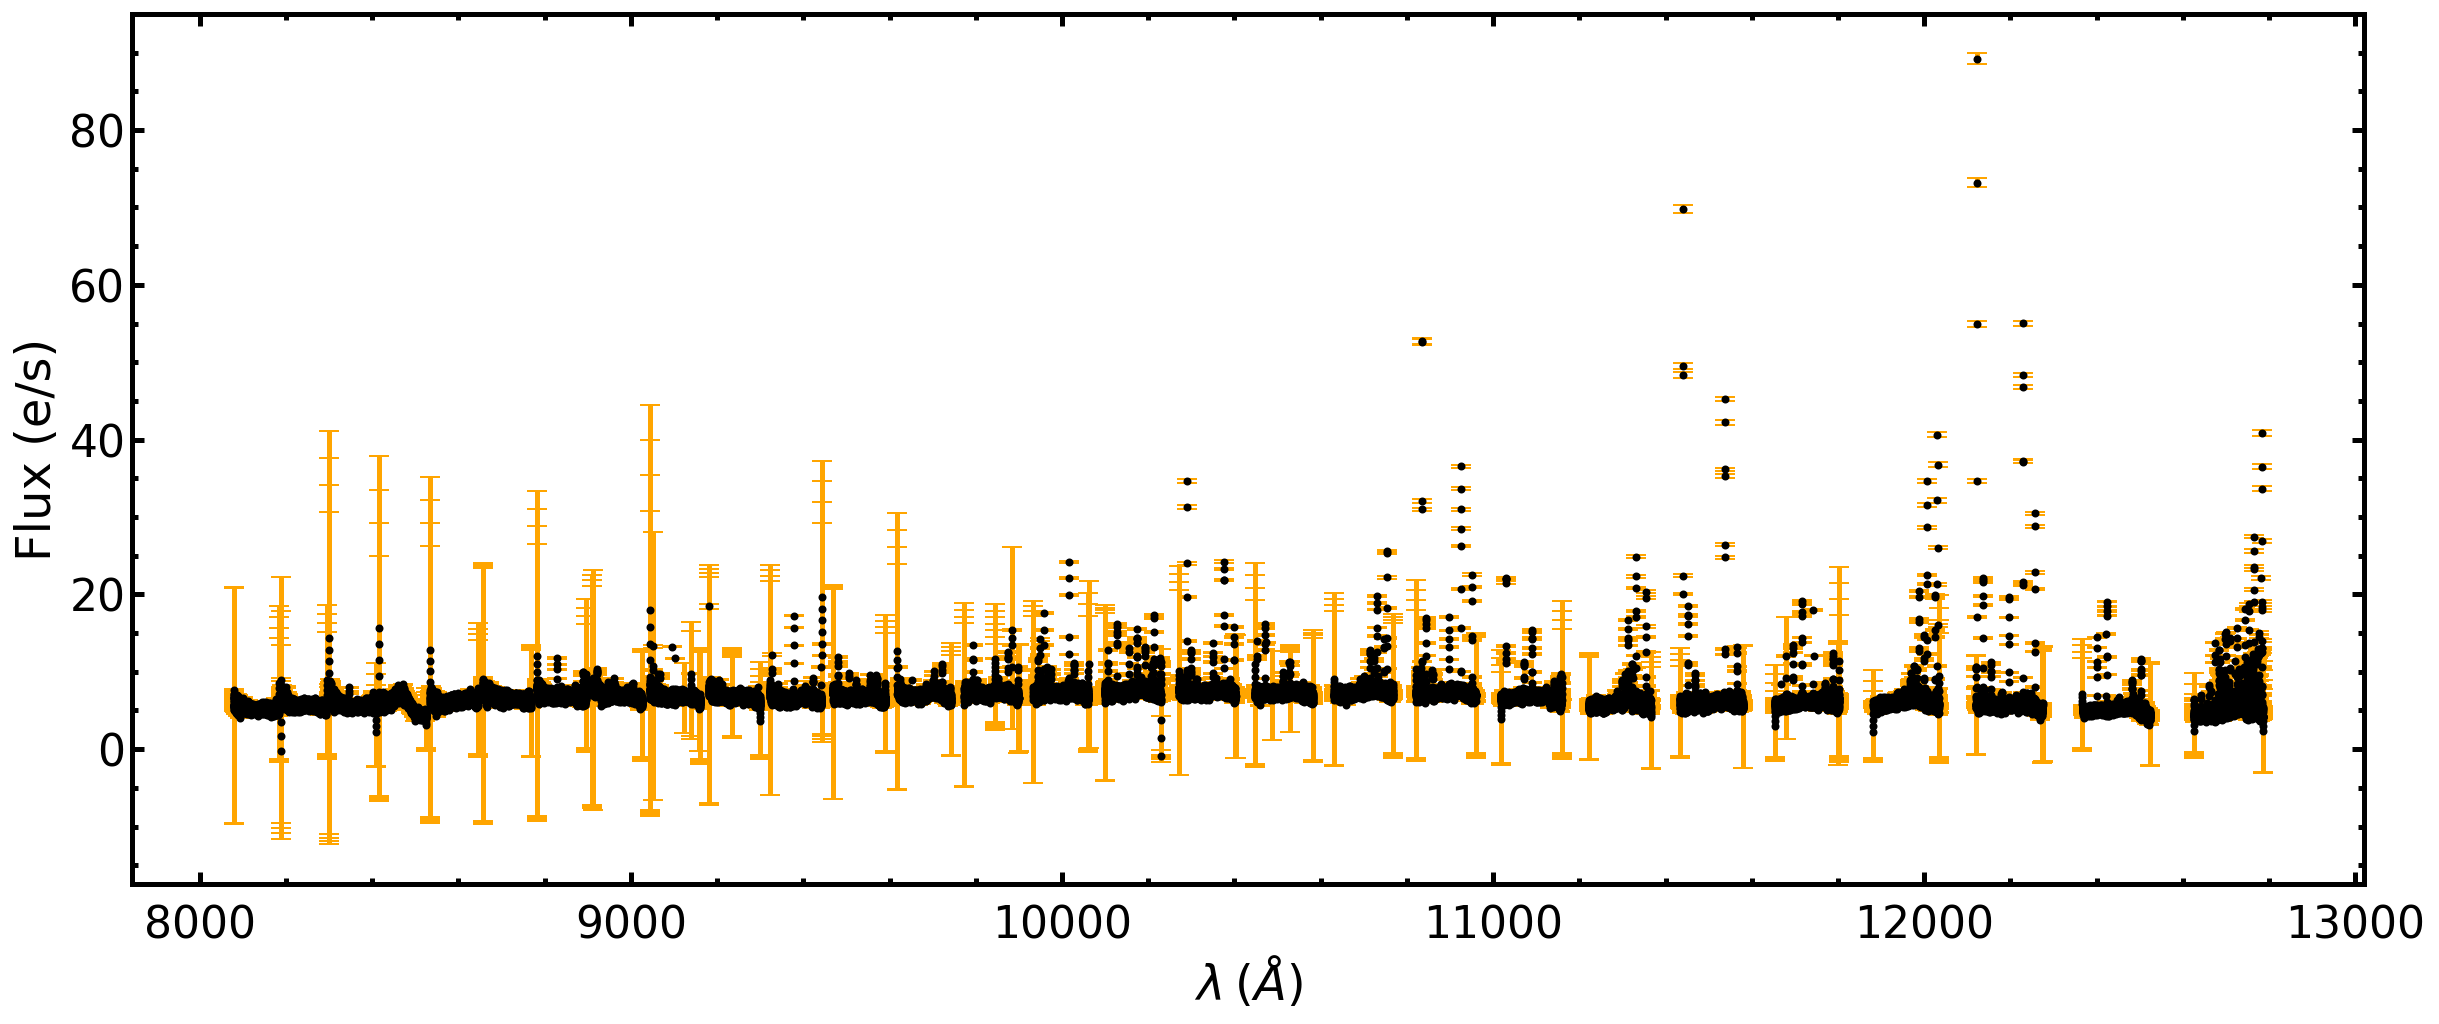

In [19]:
plt.style.use('plt_format.mplstyle')
plt.rcParams['figure.figsize'] = 20,8
xsci_GJ699, ysci_GJ699, yscivar_GJ699 = zip(*((x, y, z) for x, y, z in zip(xsci_GJ699, ysci_GJ699, yscivar_GJ699) if abs(z) <= 150))
plt.errorbar(xsci_GJ699,ysci_GJ699,yerr=yscivar_GJ699,ecolor='orange',ls='none',capsize=5,marker='o',ms=3,color='k')
plt.grid(axis='both',which='major')
plt.xlim(8000,13000)
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Flux (e/s)')
plt.show()
plt.errorbar(xsky_GJ699,ysky_GJ699,yerr=yskyvar_GJ699,ecolor='orange',ls='none',capsize=5,marker='o',ms=3,color='k')
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Flux (e/s)')
plt.show()

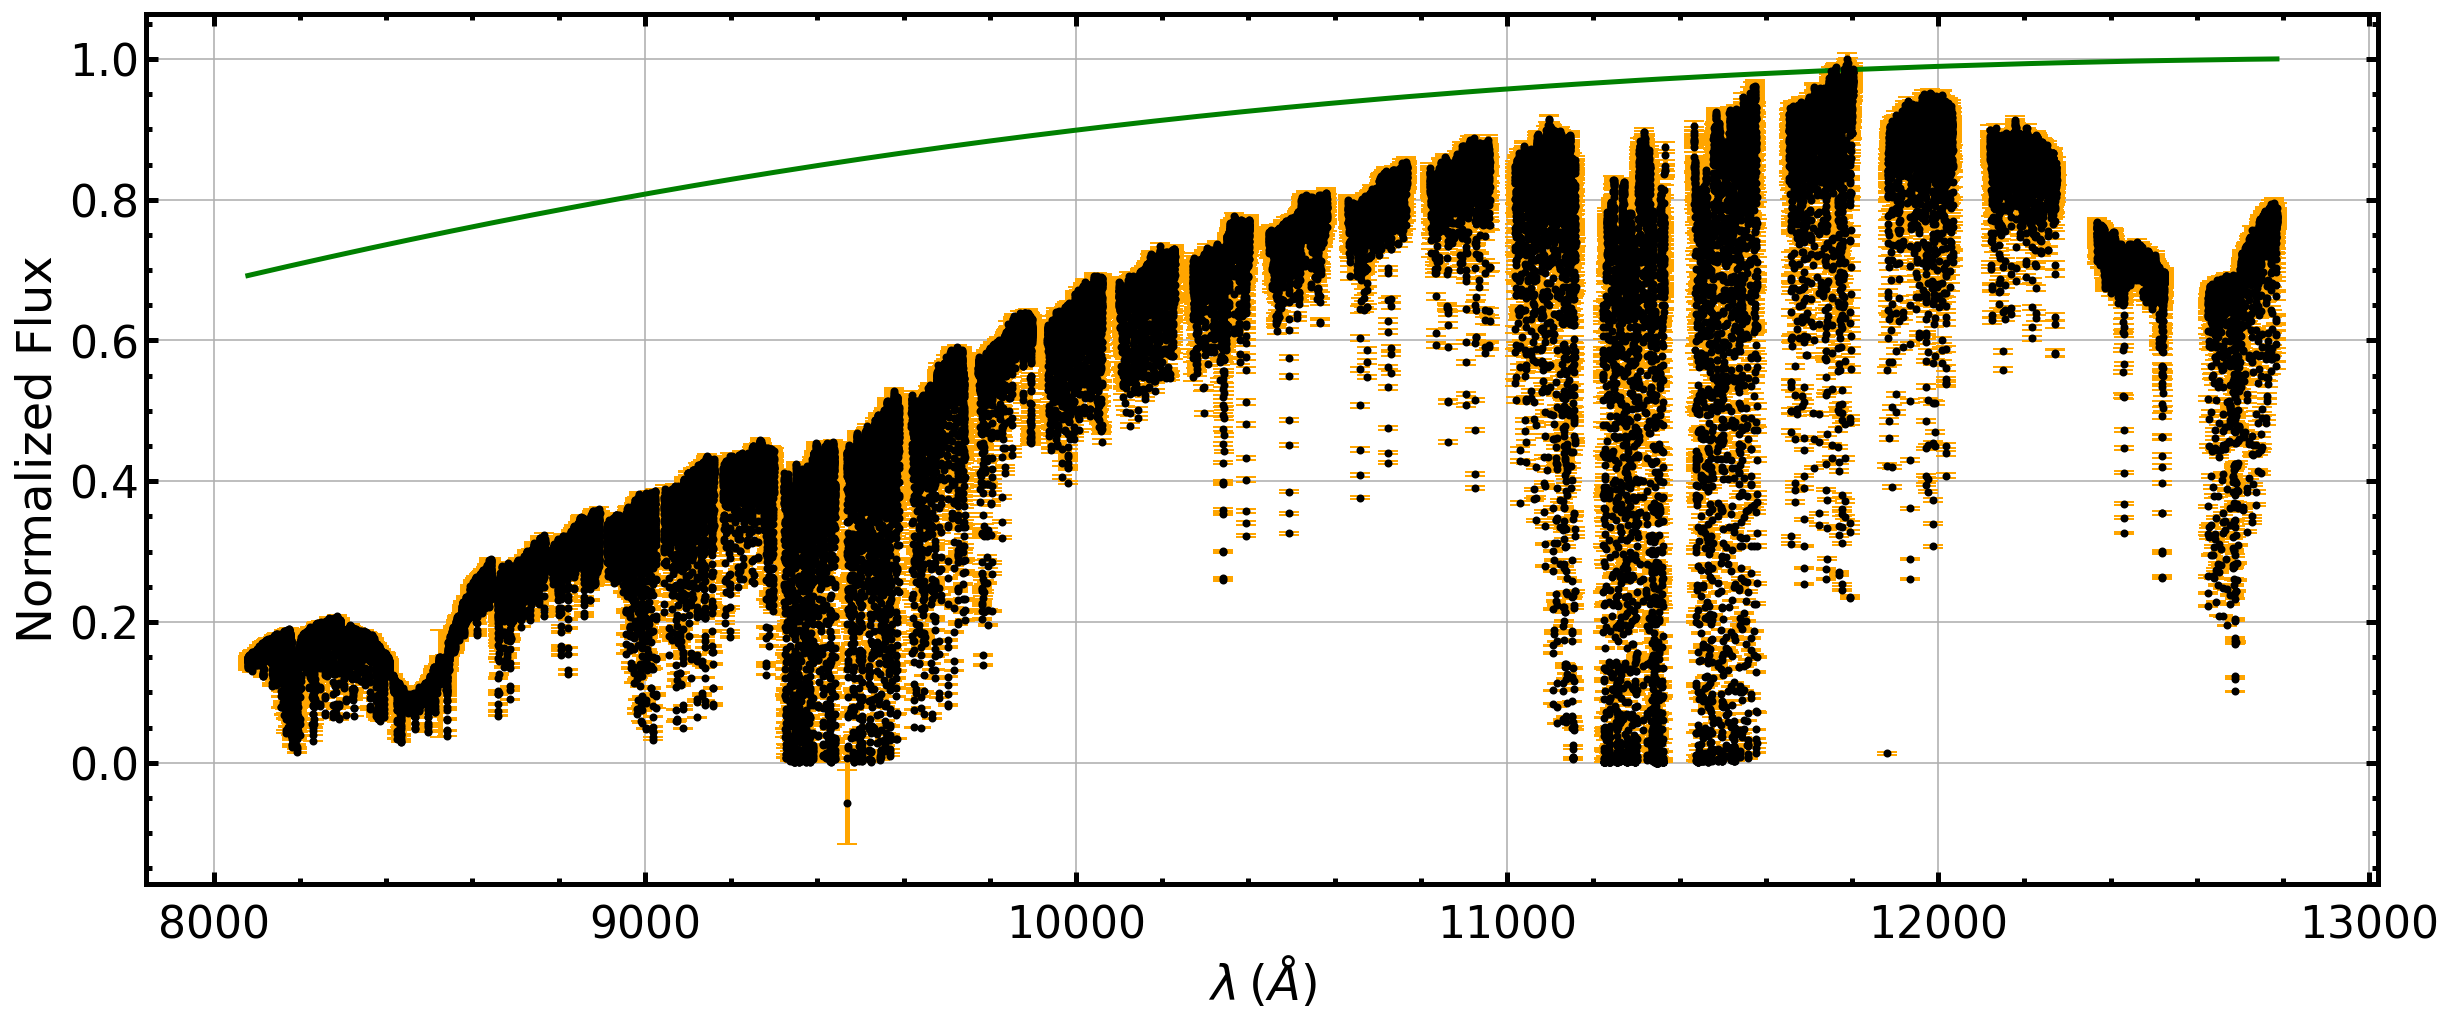

In [20]:
plt.style.use('plt_format.mplstyle')
plt.rcParams['figure.figsize'] = 20,8
xsci_GJ699, ysci_GJ699, yscivar_GJ699 = zip(*((x, y, z) for x, y, z in zip(xsci_GJ699, ysci_GJ699, yscivar_GJ699) if abs(z) <= 150))
plt.errorbar(xsci_GJ699,ysci_GJ699/max(ysci_GJ699),yerr=yscivar_GJ699/max(ysci_GJ699),ecolor='orange',ls='none',capsize=5,marker='o',ms=3,color='k')
# Blackbody model using NLTT 43564 Teff
Temp = 3857.61*u.K
BB_model = BlackBody(temperature=Temp)
BB = BB_model(xsci_GJ699*u.AA)
plt.plot(xsci_GJ699,BB/max(BB),color='g')
plt.grid(axis='both',which='major')
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Normalized Flux')
plt.show()

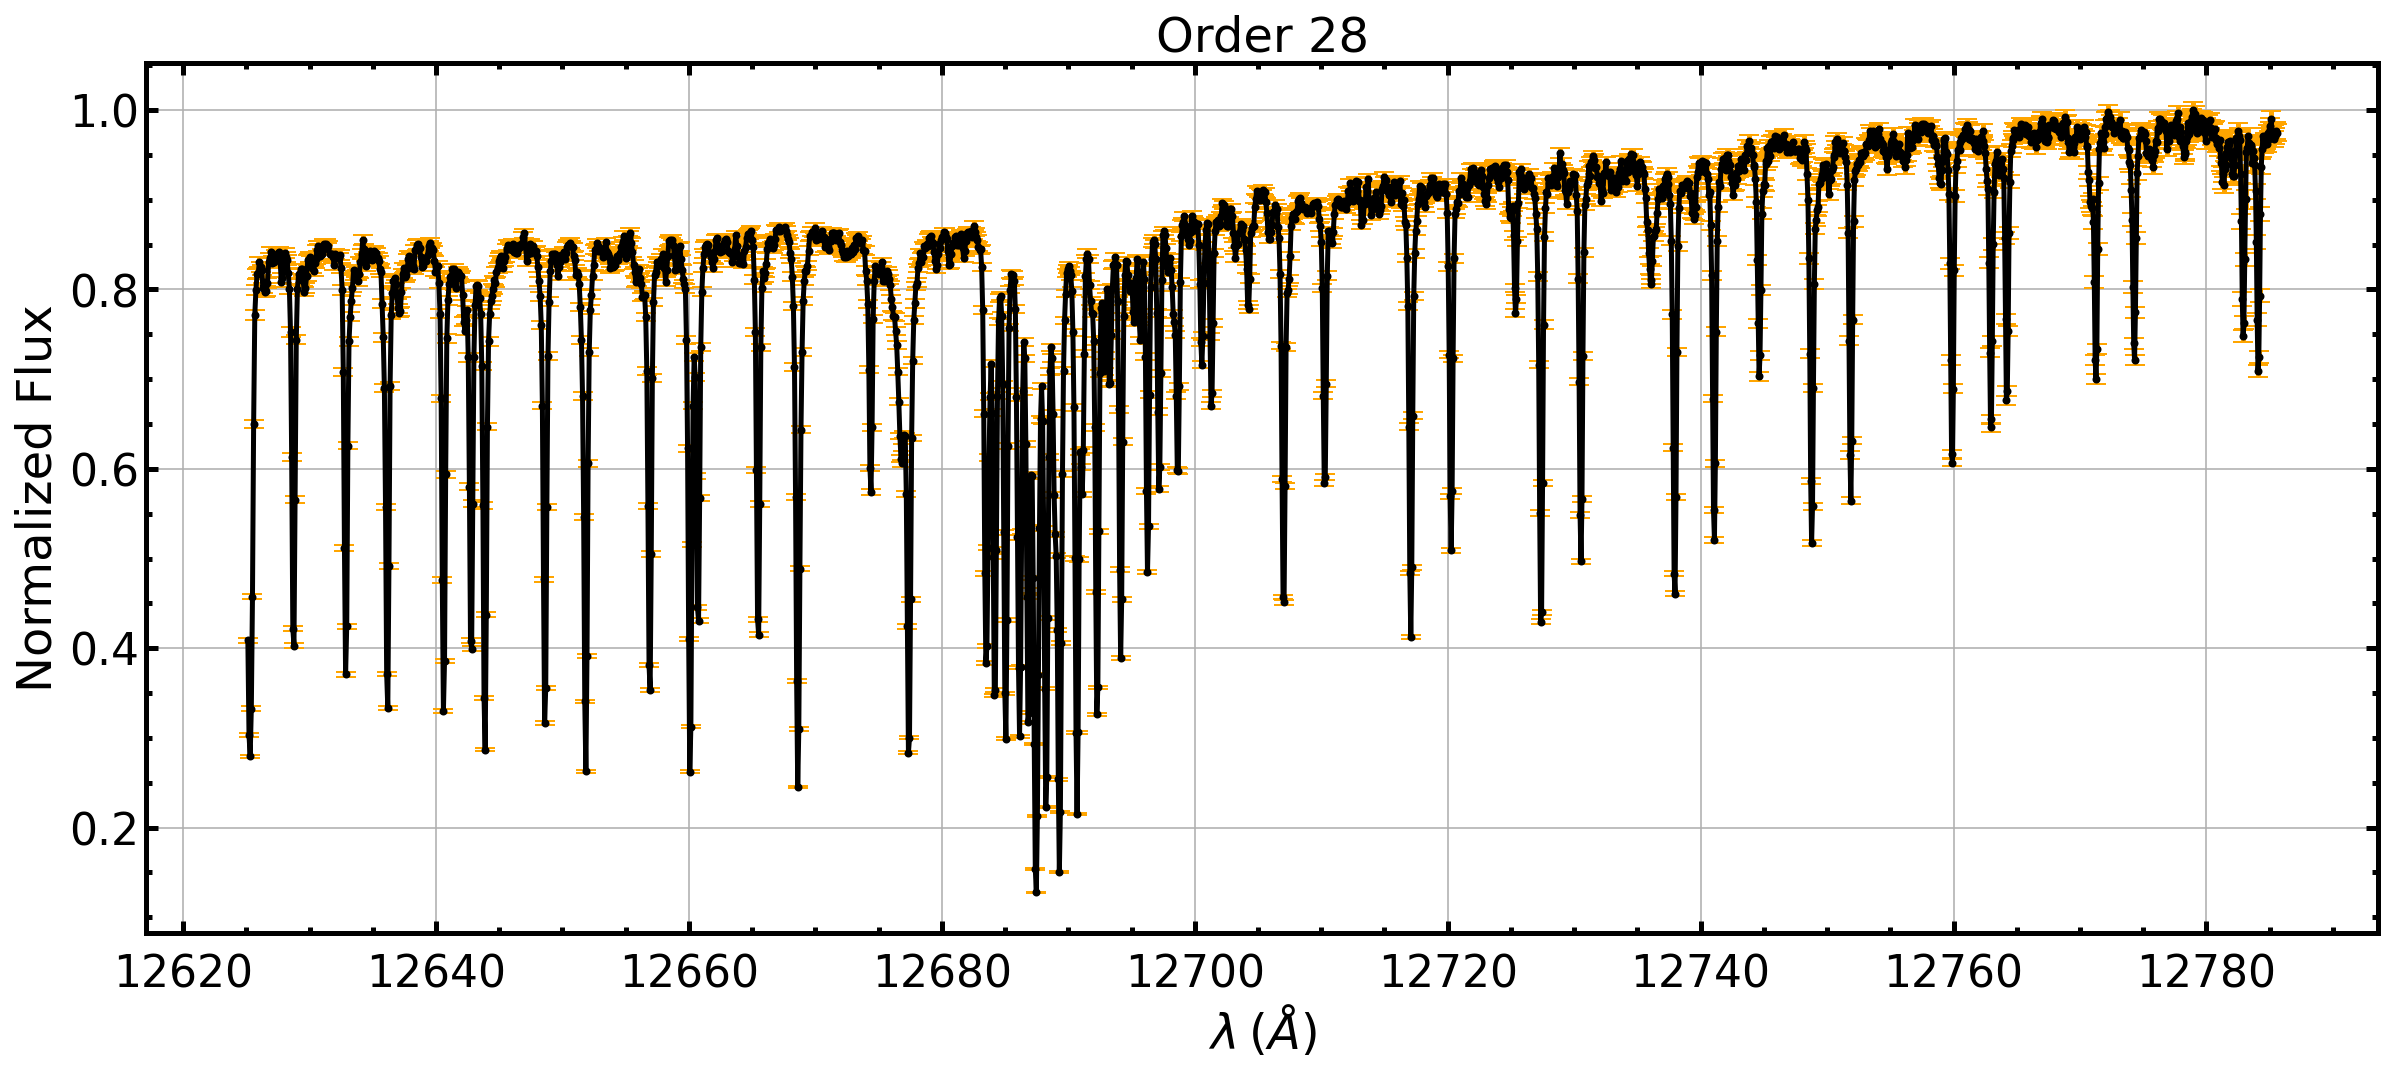

In [21]:
sci_GJ699=hdu_list_GJ699[1].data
scivar_GJ699=hdu_list_GJ699[4].data
scix_GJ699=hdu_list_GJ699[7].data
o = 28
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix_GJ699[o-1], sci_GJ699[o-1], scivar_GJ699[o-1]) if abs(z) <= 150))
plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=5,marker='o',ms=3,color='k')
plt.grid(axis='both',which='major')
plt.title(f'Order {o}')
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Normalized Flux')
plt.show()

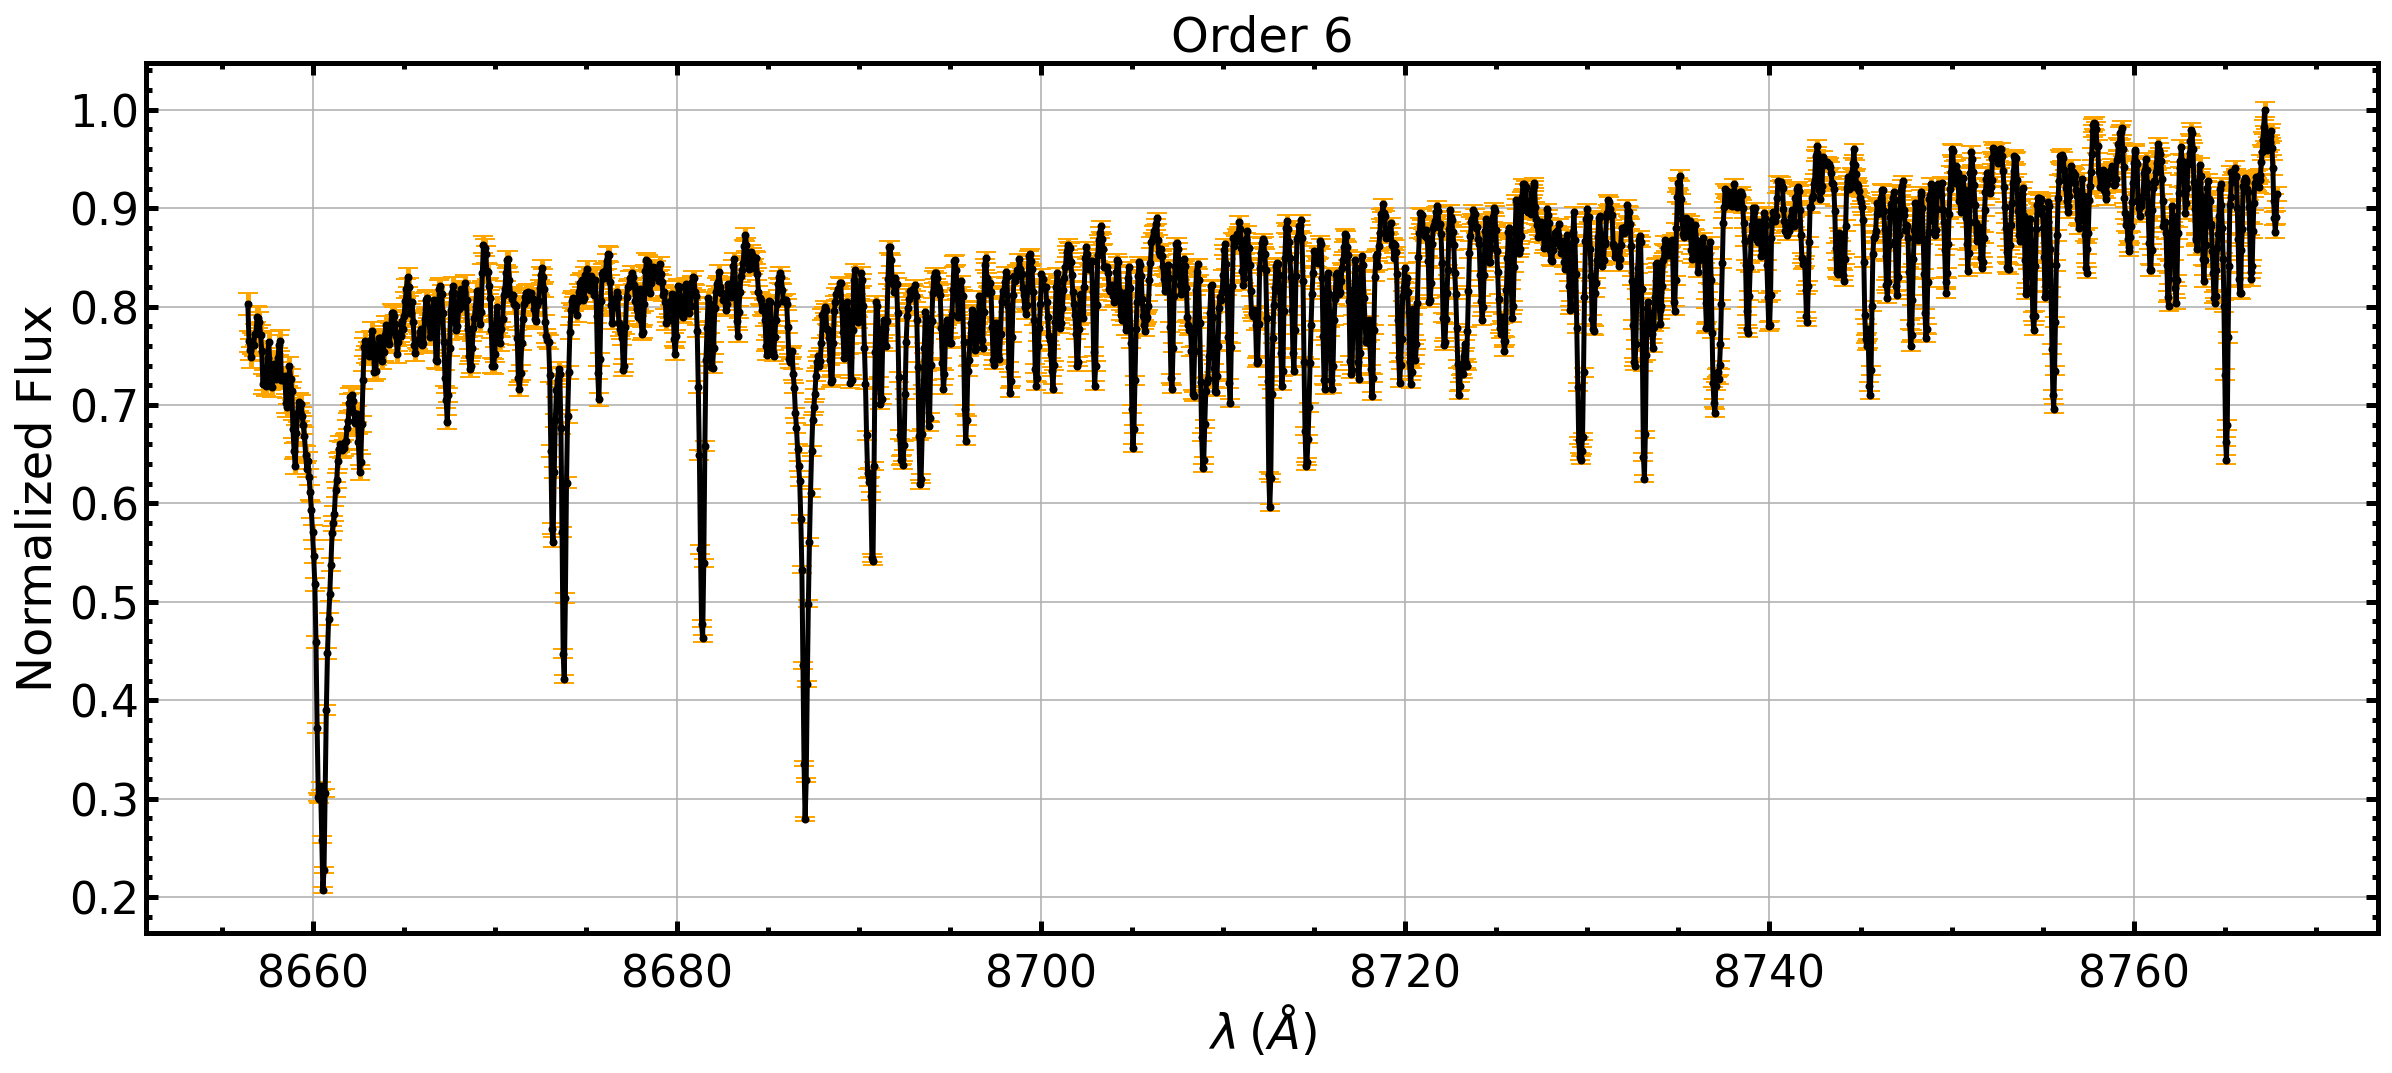

In [22]:
sci_GJ699=hdu_list_GJ699[1].data
scivar_GJ699=hdu_list_GJ699[4].data
scix_GJ699=hdu_list_GJ699[7].data
o = 6
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix_GJ699[o-1], sci_GJ699[o-1], scivar_GJ699[o-1]) if abs(z) <= 150))
plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=5,marker='o',ms=3,color='k')
plt.grid(axis='both',which='major')
plt.title(f'Order {o}')
plt.xlabel(r'$\lambda \:(\AA)$')
plt.ylabel('Normalized Flux')
plt.show()

Processing Teff=4800 K, logg=5.00, Z=+0.5: 100%|██████████| 21/21 [00:07<00:00,  2.96it/s]


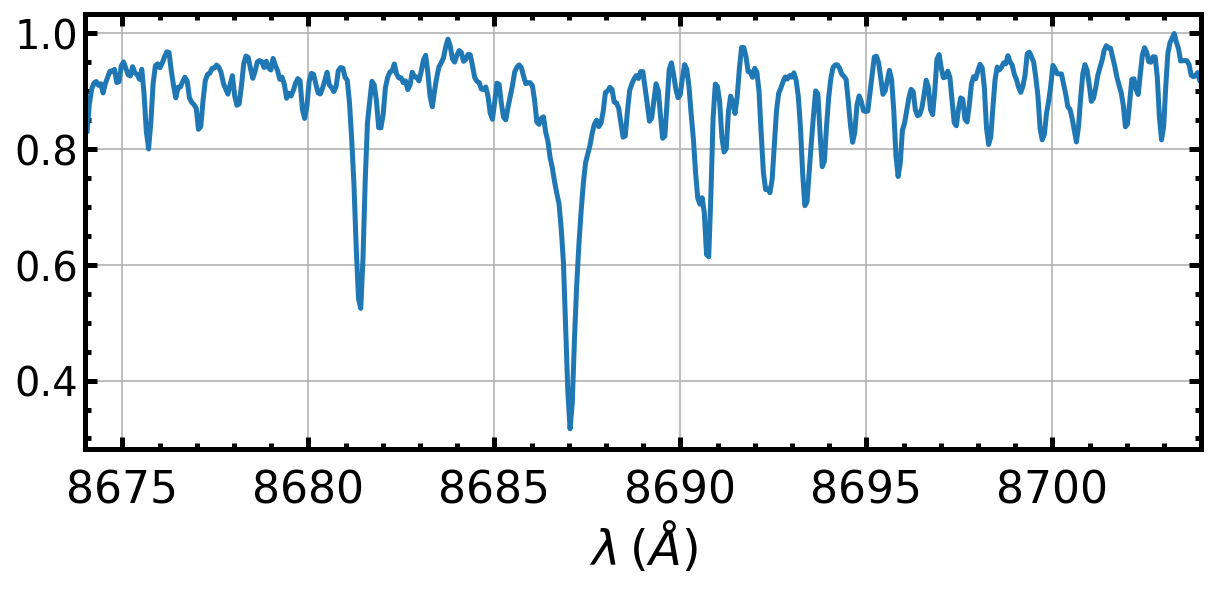

In [23]:
# Pick the order corresponding to the wavelengths you want to look at
o = 6 

# Trim the points with extra large error bars
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix_GJ699[o-1], sci_GJ699[o-1], scivar_GJ699[o-1]) if abs(z) <= 150))

# Set the bounds of your wavelenth range of interest
wl_lo=8674
wl_hi=8704

# Trim the data over this range to improve normalization
x, y, z = zip(*((x, y, z) for x, y, z in zip(x, y, z) if wl_lo <= x <= wl_hi))
plt.rcParams['figure.figsize'] = 10,4
plt.rcParams['ytick.labelsize'] = 20

# Load the grid
grid = PHOENIXGrid(wl_lo=wl_lo, wl_hi=wl_hi, path=path, 
                   teff_range=[2800,4800],
                   logg_range=[3.5,5.0],
                   metallicity_range=[-0.5,0.5])

# Then plot the data
plt.plot(x,y/max(y))
# plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=2,capthick=2,marker='o',ms=3,color='k',linewidth=1)
plt.xlabel(r'$\lambda \:(\AA)$')
plt.xlim(wl_lo,wl_hi)
plt.grid(axis='both',which='major')
plt.show()

# Finally, show the interactive dashboard
grid.show_dashboard(notebook_url='localhost:8888')

Processing Teff=4800 K, logg=5.00, Z=+0.5: 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]


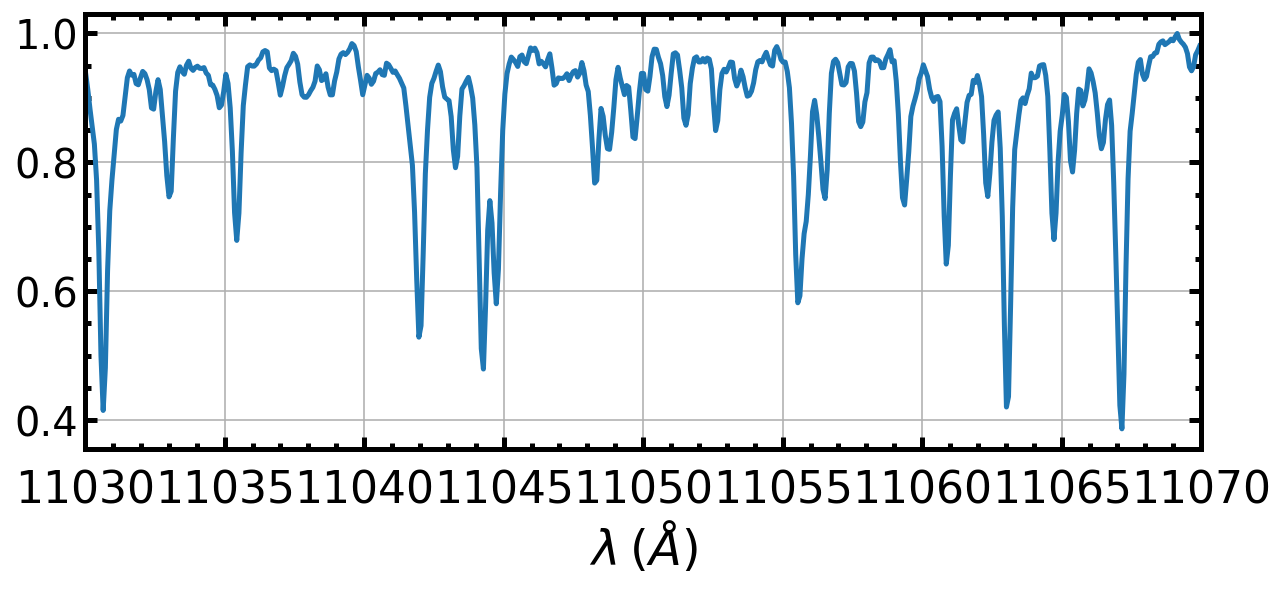

In [49]:
# Pick the order corresponding to the wavelengths you want to look at
o = 21 

# Trim the points with extra large error bars
x, y, z = zip(*((x, y, z) for x, y, z in zip(scix_GJ699[o-1], sci_GJ699[o-1], scivar_GJ699[o-1]) if abs(z) <= 150))

# Set the bounds of your wavelenth range of interest
wl_lo=11030
wl_hi=11070

# Trim the data over this range to improve normalization
x, y, z = zip(*((x, y, z) for x, y, z in zip(x, y, z) if wl_lo <= x <= wl_hi))
plt.rcParams['figure.figsize'] = 10,4
plt.rcParams['ytick.labelsize'] = 20

# Load the grid
grid = PHOENIXGrid(wl_lo=wl_lo, wl_hi=wl_hi, path=path, 
                   teff_range=[2800,4800],
                   logg_range=[3.5,5.0],
                   metallicity_range=[-0.5,0.5])

# Then plot the data
plt.plot(x,y/max(y))
# plt.errorbar(x,y/max(y),yerr=z/max(y),ecolor='orange',capsize=2,capthick=2,marker='o',ms=3,color='k',linewidth=1)
plt.xlabel(r'$\lambda \:(\AA)$')
plt.xlim(wl_lo,wl_hi)
plt.grid(axis='both',which='major')
plt.show()

# Finally, show the interactive dashboard
grid.show_dashboard(notebook_url='localhost:8888')

---
---
# Extra Stuff
---
## Can we see the K line we looked at early on in the class homework?

## Can we see the Na doublet we looked at extensively in the later homeworks?

In [50]:
wl_lo=5885
wl_hi=5900

# wl_lo=3933
# wl_hi=3936

grid = PHOENIXGrid(wl_lo=wl_lo, wl_hi=wl_hi, path=path, teff_range=[5000,6000],logg_range=[3.5,5.0],metallicity_range=[-0.5,0.5])

grid.show_dashboard(notebook_url='localhost:8888')

Processing Teff=6000 K, logg=5.00, Z=+0.5: 100%|██████████| 11/11 [00:15<00:00,  1.38s/it]
